# Notebook Trabajo Practico Final Intro. al Aprendizaje Automatico - 2024
**Grupo 14:** Trabajo Encuesta Permanaente de Hogares (EPH) - INDEC <br>
**Integrantes:** Miller Agustin, Sosa Agustina, Scarpin Julian


link del dataset:
https://www.indec.gob.ar/indec/web/Institucional-Indec-BasesDeDatos

link codigos de los empleos:
https://portal-andino.datos.gob.ar/dataset/indec-demo-encuesta-permanente-hogares-eph-2003-2015-documentos-metodologicos-clasificadores-codigos/archivo/indec-demo_1.13

## Limpieza de datos

### Importacion de librerias y datasets

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso


In [ ]:
df_indiv_T1="usu_individual_T123.xlsx"
df_indiv_T2="usu_individual_T223.xlsx"
df_indiv_T3="usu_individual_T323.xlsx"
df_indiv_T4="usu_individual_T423.xlsx"
codigos_empleos_nombre="codigos_ocupaciones.csv"

#### Correr en colab

Cargamos solo los datos del primer trimestre



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
directorio_drive = '/content/drive/MyDrive/Tp_final/Datasets/'

df_eph_2023_indiv_t1= pd.read_excel(directorio_drive + df_indiv_T1)
#data_indiv_T2= pd.read_excel(directorio_drive + df_indiv_T2)
#data_indiv_T3= pd.read_excel(directorio_drive + df_indiv_T3)
#data_indiv_T4= pd.read_excel(directorio_drive + df_indiv_T4)

codigos_empleos= pd.read_csv(directorio_drive + codigos_empleos_nombre)

#### Correr en VS

Cargamos solo los datos del primer trimestre

In [ ]:
directorio_casa = '/content/drive/MyDrive/Tp_final/Datasets/'

data_indiv_T1 = os.path.join(directorio_casa,df_indiv_T1)
#data_indiv_T2 = os.path.join(directorio_casa,df_indiv_T2)
#data_indiv_T3 = os.path.join(directorio_casa,df_indiv_T3)
#data_indiv_T4 = os.path.join(directorio_casa,df_indiv_T4)

df_eph_2023_indiv_t1= pd.read_excel(data_indiv_T1)
#df_eph_2023_indiv_t2= pd.read_excel(data_indiv_T2)
#df_eph_2023_indiv_t3= pd.read_excel(data_indiv_T3)
#df_eph_2023_indiv_t4= pd.read_excel(data_indiv_T4)

data_codigo_empleos = os.path.join(directorio_casa,codigos_empleos_nombre)
codigos_empleos = pd.read_csv(data_codigo_empleos, sep=';')


In [ ]:
list_dataframes_individuos = [df_eph_2023_indiv_t1]


Unimos los dos datasets

In [ ]:
list_dataframes_individuos = [df.merge(codigos_empleos, left_on='PP04B_COD', right_on='PP04B_COD', how='inner') for df in list_dataframes_individuos]

### Funciones para limpiar el dataset

In [ ]:
def drop_nan(list_dataframes, columnas_drop_nan):
    for df in list_dataframes:
        columnas_drop_nan_existentes = [col for col in columnas_drop_nan if col in df.columns]
        df.dropna(subset=columnas_drop_nan_existentes, inplace=True)
    return list_dataframes

def drop_valores_mal_cargados(list_dataframes, columnas_drop_valores_mal_cargados):
    for i in range(len(list_dataframes)):
        for columna in columnas_drop_valores_mal_cargados:
            if columna in list_dataframes[i].columns:
                list_dataframes[i] = list_dataframes[i].loc[list_dataframes[i][columna] != 0]
                list_dataframes[i] = list_dataframes[i].loc[list_dataframes[i][columna] !=-9]
                list_dataframes[i] = list_dataframes[i].loc[list_dataframes[i][columna] != 9]
                list_dataframes[i] = list_dataframes[i].loc[list_dataframes[i][columna] != 99]
                list_dataframes[i] = list_dataframes[i].loc[list_dataframes[i][columna] != 999]
                list_dataframes[i] = list_dataframes[i].loc[list_dataframes[i][columna] != 9999]
    return list_dataframes

def eliminar_columnas(list_dataframes, columnas_a_borrar):
    for df in list_dataframes:
        columnas_a_borrar_existentes = [col for col in columnas_a_borrar if col in df.columns]
        df.drop(columnas_a_borrar_existentes, axis=1, inplace=True)
    return list_dataframes

def reemplazo_valores(list_dataframes, lista_variables_reemplazo_val, codes_to_names):
    """
    Reemplaza los valores de las variables de los datasets por sus nombres correspondientes.

    Parámetros:
    list_dataframes (list of pandas.DataFrame): La lista de datasets donde se realizará el reemplazo.
    variables (list of str): La lista de nombres de las variables a modificar.
    codes_to_names (list of dict): Una lista de diccionarios que mapean los códigos de las regiones a sus nombres.

    Retorno:
    list of pandas.DataFrame: La lista de datasets con los códigos de las regiones reemplazados por sus nombres.
    """
    for variable, code_to_name_dict in zip(lista_variables_reemplazo_val, codes_to_names):
        # Extraer el diccionario de reemplazo real de code_to_name_dict
        code_to_name = list(code_to_name_dict.values())[0]
        for dataset in list_dataframes:
            if variable in dataset.columns:
                dataset[variable] = dataset[variable].replace(code_to_name)
    return list_dataframes

def rename_columns(dataframes, column_dict):
    """
    Renombra las columnas en una lista de dataframes.

    Parámetros:
    dataframes (list of pandas.DataFrame): La lista de dataframes donde se realizará el cambio de nombre.
    column_dict (dict): Un diccionario que mapea los nombres actuales de las columnas a los nuevos nombres.

    Retorno:
    list of pandas.DataFrame: La lista de dataframes con los nombres de las columnas cambiados.
    """
    for dataframe in dataframes:
        dataframe.rename(columns=column_dict, inplace=True)
    return dataframes

def unir_valores_variables(list_dataframes, list_variables_a_unificar, list_values_to_unify, unified_value_name):
    """
    Une los valores de una lista de variables para los distintos datasets en una nueva variable unificada.

    Parámetros:
    list_dataframes (list of pandas.DataFrame): La lista de dataframes donde se realizará la unión de valores.
    list_variables_a_unificar (list of str): La lista de nombres de las variables a unificar.
    list_values_to_unify (list of list): Lista de listas de valores a unificar.
    unified_value_name (str): El nombre de la nueva variable unificada.

    Retorno:
    list of pandas.DataFrame: La lista de dataframes con la nueva variable unificada.
    """
    for dataframe, variable, values_to_unify in zip(list_dataframes, list_variables_a_unificar, list_values_to_unify):
        # Crear un diccionario para mapear los valores a unificar a la nueva variable unificada
        dict_replace = {value: unified_value_name for value in values_to_unify}

        # Reemplazar los valores en el dataframe
        dataframe[variable] = dataframe[variable].replace(dict_replace)
    return list_dataframes

def apply_all_functions(list_dataframes, columnas_drop_nan, columnas_drop_valores_mal_cargados, columnas_a_borrar, lista_variables_reemplazo_val, codes_to_names, column_dict, list_variables_a_unificar, list_values_to_unify, unified_value_name):
    """
    Aplica todas las funciones de limpieza y transformación a una lista de dataframes.

    Parámetros:
    list_dataframes (list of pandas.DataFrame): La lista de dataframes a limpiar y transformar.
    columnas_drop_nan (list of str): La lista de columnas a borrar en la función drop_nan.
    columnas_drop_valores_mal_cargados (list of str): La lista de columnas a borrar en la función drop_valores_mal_cargados.
    columnas_a_borrar (list of str): La lista de columnas a borrar en la función eliminar_columnas.
    lista_variables_reemplazo_val (list of str): La lista de nombres de las variables a modificar en la función reemplazo_valores.
    codes_to_names (list of dict): Una lista de diccionarios que mapean los códigos de las variables a sus nombres en la función reemplazo_valores.
    column_dict (dict): Un diccionario que mapea los nombres actuales de las columnas a los nuevos nombres en la función rename_columns.
    list_variables_a_unificar (list of str): La lista de nombres de las variables a unificar en la función unir_valores_variables.
    list_values_to_unify (list of list): Lista de listas de valores a unificar en la función unir_valores_variables.
    unified_value_name (str): El nombre de la nueva variable unificada en la función unir_valores_variables.

    Retorno:
    list of pandas.DataFrame: La lista de dataframes limpiados y transformados.
    """
    list_dataframes = eliminar_columnas(list_dataframes, columnas_a_borrar)
    list_dataframes = drop_nan(list_dataframes, columnas_drop_nan)
    list_dataframes = drop_valores_mal_cargados(list_dataframes, columnas_drop_valores_mal_cargados)
    list_dataframes = reemplazo_valores(list_dataframes, lista_variables_reemplazo_val, codes_to_names)
    list_dataframes = rename_columns(list_dataframes, column_dict)
    list_dataframes = unir_valores_variables(list_dataframes, list_variables_a_unificar, list_values_to_unify, unified_value_name)
    return list_dataframes

### Lista de cambios

In [ ]:

columnas_drop_nan= ['CH03', 'CH04', 'CH05', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10', 'CH12', 'CH13',
       'CH15', 'CH16', 'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'INTENSI', 'PP04A',
       'PP04B_COD', 'PP07A', 'PP07C', 'PP07F1', 'PP07F2',
       'PP07F3', 'PP07F4', 'PP07G1', 'PP07G2', 'PP07G3', 'PP07G4',
       'PP07G_59', 'PP07H', 'PP07I', 'PP07J', 'PP07K', 'P47T', 'P21']

columnas_drop_valores_mal_cargados = ['CH03', 'CH04', 'CH05', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10', 'CH12', 'CH13',
       'CH15', 'CH16', 'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'INTENSI', 'PP04A',
       'PP04B_COD', 'PP07A', 'PP07C', 'PP07F1', 'PP07F2',
       'PP07F3', 'PP07F4', 'PP07G1', 'PP07G2', 'PP07G3', 'PP07G4',
       'PP07H', 'PP07I', 'PP07J', 'PP07K', 'P47T', 'P21']

columnas_a_borrar = ['ANO4', 'TRIMESTRE', 'MAS_500','CH03', 'CH05', 'PP04B_COD',
                     'P47T',
                     "H15",'CODUSU', 'NRO_HOGAR', 'COMPONENTE', 'PONDERA', "CH11", 'CH14', 'CH15_COD', 'CH16_COD', 'CAT_INAC', 'IMPUTA',
                     'PP02C1', 'PP02C2', 'PP02C3', 'PP02C4', 'PP02C5', 'PP02C6', 'PP02C7', 'PP02C8', 'PP02E', 'PP02H', 'PP02I',
                     'PP03C', 'PP03D', 'PP3E_TOT', 'PP3F_TOT', 'PP03G', 'PP03H', 'PP03I', 'PP03J',
                     'PP04B1', 'PP04B2', 'PP04B3_MES', 'PP04B3_ANO', 'PP04B3_DIA', 'PP04C', 'PP04C99', 'PP04D_COD', 'PP04G',
                     'PP05B2_MES', 'PP05B2_ANO', 'PP05B2_DIA', 'PP05C_1', 'PP05C_2', 'PP05C_3', 'PP05E', 'PP05F', 'PP05H', 'PP06A',
                     'PP06C', 'PP06D', 'PP06E', 'PP06H',
                     "PP07D","PP07E", "PP07F5","PP07G_59",
                     'PP08D1', 'PP08D4', 'PP08F1', 'PP08F2', 'PP08J1', 'PP08J2', 'PP08J3',
                     'PP09A', 'PP09A_ESP', 'PP09B', 'PP09C', 'PP09C_ESP',
                     'PP10A', 'PP10C', 'PP10D', 'PP10E',
                     'PP11A',
                     'PP11B_COD', 'PP11B1', 'PP11B2_MES', 'PP11B2_ANO', 'PP11B2_DIA',
                     'PP11C', 'PP11C99', 'PP11D_COD',
                     'PP11G_ANO', 'PP11G_MES', 'PP11G_DIA', 'PP11L', 'PP11L1', 'PP11M', 'PP11N', 'PP11O', 'PP11P', 'PP11Q', 'PP11R', 'PP11S', 'PP11T',
                     'DECOCUR', 'IDECOCUR', 'RDECOCUR', 'GDECOCUR', 'PDECOCUR', 'ADECOCUR', 'PONDIIO',
                     'TOT_P12', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI',
                     'ITF', 'DECIFR', 'IDECIFR', 'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR',
                     'IPCF', 'DECCFR', 'IDECCFR', 'RDECCFR', 'GDECCFR', 'PDECCFR', 'ADECCFR', 'PONDIH',
                     'DECINDR', 'IDECINDR', 'RDECINDR', 'GDECINDR', 'PDECINDR', 'ADECINDR', 'PONDII',
                     'PP04B_label', 'caes_seccion_cod', 'caes_division_cod', 'caes_division_label', 'caes_eph_cod', 'caes_eph_label', 'caes_version']

lista_variables_reemplazo_val =[
    "MAS_500", "REGION", "AGLOMERADO","CH07", "CH08", "CH12", "CH15", "CH16",
    "NIVEL_ED", "ESTADO", "CAT_OCUP", "INTENSI", "PP04A",
    "PP07J", "PP07K"]

codes_to_names= [
    {"MAS_500": {"S": 0, "N": 1}},
    {"REGION": {1: "Gran Buenos Aires", 40: "Noroeste", 41: "Noreste", 42: "Cuyo", 43: "Pampeana", 44: "Patagonia"}},
    {"AGLOMERADO": {
        2: "Gran La Plata",
        3: "Bahía Blanca - Cerri",
        4: "Gran Rosario",
        5: "Gran Santa Fé",
        6: "Gran Paraná",
        7: "Posadas",
        8: "Gran Resistencia",
        9: "Comodoro Rivadavia - Rada Tilly",
        10: "Gran Mendoza",
        12: "Corrientes",
        13: "Gran Córdoba",
        14: "Concordia",
        15: "Formosa",
        17: "Neuquén – Plottier",
        18: "Santiago del Estero - La Banda",
        19: "Jujuy - Palpalá",
        20: "Río Gallegos",
        22: "Gran Catamarca",
        23: "Gran Salta",
        25: "La Rioja",
        26: "Gran San Luis",
        27: "Gran San Juan",
        29: "Gran Tucumán - Tafí Viejo",
        30: "Santa Rosa – Toay",
        31: "Ushuaia - Río Grande",
        32: "Ciudad Autónoma de Buenos Aires",
        33: "Partidos del GBA",
        34: "Mar del Plata",
        36: "Río Cuarto",
        38: "San Nicolás – Villa Constitución",
        91: "Rawson – Trelew",
        93: "Viedma – Carmen de Patagones"}},
    {"CH07": {
        1: "Unido/a",
        2: "Casado/a",
        3: "Separado/a o divorciado/a",
        4: "Viudo/a",
        5: "Soltero/a"}},
    {"CH08": {
        1: "Obra social (incluye PAMI)",
        2: "Mutual / prepaga / servicio de emergencia",
        3: "Planes y seguros públicos",
        4: "No paga ni le descuentan",
        9: "Ns/Nr",
        12: "Obra social y mutual / prepaga / servicio de emergencia",
        13: "Obra social y planes y seguros públicos",
        23: "Mutual / prepaga / servicio de emergencia / Planes y seguros públicos",
        123: "Obra social, mutual / prepaga / servicio de emergencia y planes y seguros públicos"}},
    {"CH12": {
        1: "Jardín/preescolar",
        2: "Primario",
        3: "EGB",
        4: "Secundario",
        5: "Secundario",
        6: "Terciario",
        7: "Universitario",
        8: "Posgrado universitario",
        9: "Educación especial (discapacitado)"}},
    {"CH15": {
        1: "esta_localidad",
        2: "otra_localidad_de_esta_provincia",
        3: "otra_provincia",
        4: "país_limítrofe",
        5: "otro_país",
        9: "Ns/Nr"}},
    {"CH16": {
        1: "esta_localidad",
        2: "otra_localidad_de_esta_provincia",
        3: "otra_provincia",
        4: "país_limítrofe",
        5: "otro_país",
        6: "No_había_nacido",
        9: "Ns/Nr"}},
    {"NIVEL_ED": {
        1: 2,
        2: 3,
        3: 4,
        4: 5,
        5: 6,
        6: 7,
        7: 1,
        9: "Ns/Nr"}},
    {"ESTADO": {
        1: "Ocupado",
        2: "Desocupado",
        3: "Inactivo",
        4: "Menor de 10 años"}},
    {"CAT_OCUP": {
        1: "Patrón",
        2: "Cuenta propia",
        3: "Obrero o empleado",
        4: "Trabajador familiar sin remuneración",
        9: "Ns/Nr"}},
    {"INTENSI": {
        1: "Subocupado por insuficiencia horaria",
        2: "Ocupado pleno",
        3: "Sobreocupado",
        4: "Ocupado que no trabajó en la semana",
        9: "Ns/Nr"}},
    {"PP04A": {
        1: "estatal",
        2: "privada",
        3: "otro"}},
    {"PP07J": {
        1: "día",
        2: "noche",
        3: "rotativo",}},
    {"PP07K": {
        1: "recibo_con_sello",
        2: "recibo_sin_sello",
        3: "entrega_factura",
        4: "no_le_dan_nada",
        5: "no cobra/ad honorem"}}
    ]

column_dict = {
    "CH03": "Parentesco",
    "CH04": "Sexo",
    "CH05": "Fecha_nacimiento",
    "CH06": "Edad",
    "CH07": "Estado_civil",
    "CH08": "Obra_social",
    "CH09": "¿Sabe_leer_y_escribir?",
    "CH10": "Asiste_o_asistió_a_algún_establecimiento_educativo",
    "CH12": "Nivel_más_alto_que_cursa_o_cursó?",
    "CH13": "¿Finalizó_1_ese_nivel?",
    "CH15": "Lugar_nacimiento",
    "CH16": "Dónde_vivía_hace_5_años",
    "NIVEL_ED": "Nivel_educativo",
    "ESTADO": "Estado_laboral",
    "CAT_OCUP": "Categoria_ocupacional",
    'PP03D': "Cantidad de ocupaciones",
    'PP3E_TOT':"Total_horas_ocupación_principal",
    'PP3F_TOT':"Total_horas_ocupación_secundaria",
    'PP03G':"queria_trabajar_mas_horas",
    "INTENSI": "Intensidad_laboral",
    "PP04A": "Tipo_de_empleo",
    "PP07A": "Tiempo_de_trabajo_continuo",
    "PP07C": "¿Ese_empleo_tiene_tiempo_de_finalización?",
    "PP07F1": "dan_comida",
    "PP07F2": "dan_vivienda",
    "PP07F3": "dan_mercaderia",
    "PP07F4": "dan_otro_beneficio",
    "PP07G1": "tiene_vacaciones_pagas",
    "PP07G2": "tiene_aguinaldo",
    "PP07G3": "tiene_dias_por_enfermedad",
    "PP07G4": "tiene_obra_social",
    "PP07H": "tiene_descuento_jubilatorio",
    "PP07I": "aporta_a_su_jubilacion",
    "PP07J": "turno_trabajo",
    "PP07K": "metodo_pago",
}
list_variables_a_unificar= []
list_values_to_unify= []
unified_value_name= "Otros"

#### Aplico las funciones

In [ ]:
list_dataframes_limpios_individuos=apply_all_functions(list_dataframes_individuos, columnas_drop_nan, columnas_drop_valores_mal_cargados, columnas_a_borrar, lista_variables_reemplazo_val, codes_to_names, column_dict, list_variables_a_unificar, list_values_to_unify, unified_value_name)
df_individuos_limpio_primer_trimestre = list_dataframes_limpios_individuos[0]
#df_individuos_limpio_cuarto_trimestre = list_dataframes_limpios_individuos[1]

## Creación de modelos


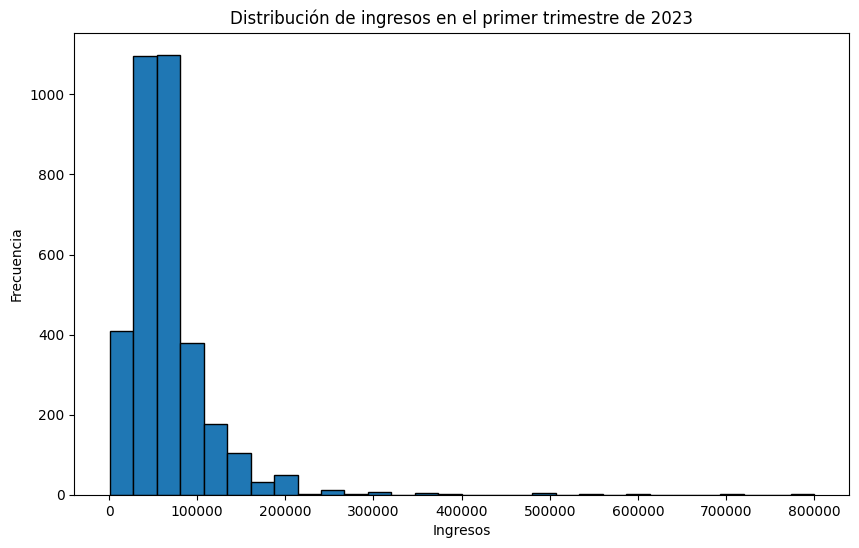

In [ ]:
# Crear el histograma
plt.figure(figsize=(10,6))
plt.hist(df_individuos_limpio_primer_trimestre['P21'], bins=30, edgecolor='black')
plt.title('Distribución de ingresos en el primer trimestre de 2023')
plt.xlabel('Ingresos')
plt.ylabel('Frecuencia')
plt.show()
# Escalado no-lineal de la variable P21

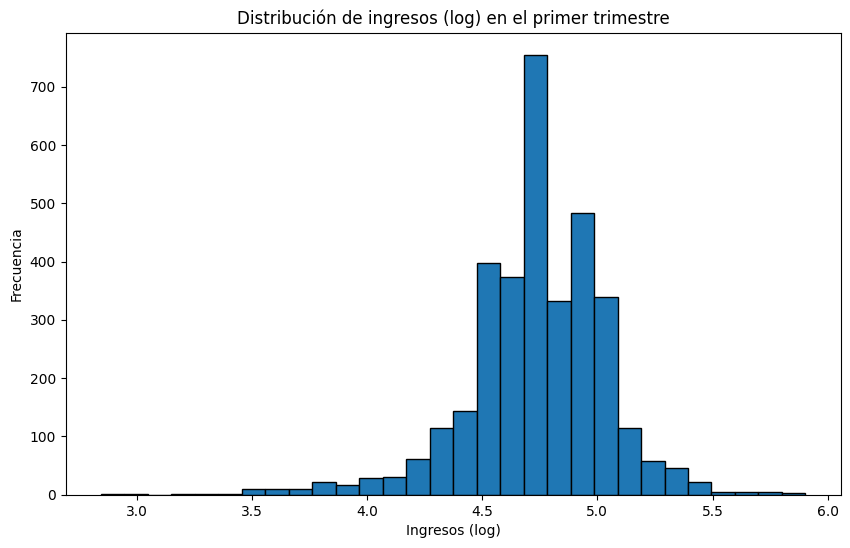

In [ ]:

df_individuos_limpio_primer_trimestre['P21_log'] = np.log10(df_individuos_limpio_primer_trimestre['P21'])
df_limpio = df_individuos_limpio_primer_trimestre.copy()

plt.figure(figsize=(10,6))
plt.hist(df_limpio['P21_log'], bins=30, edgecolor='black')
plt.title('Distribución de ingresos (log) en el primer trimestre')
plt.xlabel('Ingresos (log)')
plt.ylabel('Frecuencia')
plt.show()


### Primer modelo solo con sexo, edad y nivel eduativo

#### Modelo solo con sexo, edad y nivel eduativo

In [ ]:
varaibles_no_utilzadas=['REGION',  'AGLOMERADO',
       'Estado_civil', 'Obra_social',
       '¿Sabe_leer_y_escribir?',
       'Asiste_o_asistió_a_algún_establecimiento_educativo',
       'Nivel_más_alto_que_cursa_o_cursó?', '¿Finalizó_1_ese_nivel?',
       'Lugar_nacimiento', 'Dónde_vivía_hace_5_años',
       'Estado_laboral', 'Categoria_ocupacional', 'Intensidad_laboral',
       'Tipo_de_empleo','Tiempo_de_trabajo_continuo',
       '¿Ese_empleo_tiene_tiempo_de_finalización?', 'dan_comida',
       'dan_vivienda', 'dan_mercaderia', 'dan_otro_beneficio',
       'tiene_vacaciones_pagas', 'tiene_aguinaldo',
       'tiene_dias_por_enfermedad', 'tiene_obra_social',
       'tiene_descuento_jubilatorio', 'aporta_a_su_jubilacion',
       'turno_trabajo', 'metodo_pago', "P21",'caes_seccion_label']

for variable in varaibles_no_utilzadas:
    if variable in df_limpio.columns:
        del df_limpio[variable]
    else:
        print(variable, "no esta en el dataset")

X=df_limpio.drop(columns='P21_log')
y=df_limpio['P21_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_1 = LinearRegression()
modelo_1.fit(X_train, y_train)
coefficients = modelo_1.coef_
intercept = modelo_1.intercept_
score = modelo_1.score(X_test, y_test)
coef_df = pd.DataFrame(coefficients, X.columns, columns=['Coefficient'])
intercept_df = pd.DataFrame(data=[intercept], columns=['Intercept'])
y_pred = modelo_1.predict(X_test)
print(f"Model score: {score}")
print("")
print(coef_df)
print("")
print(intercept_df)
print("")
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))


AGLOMERADO no esta en el dataset
Model score: 0.06956910146548712

                 Coefficient
Unnamed: 8          0.000141
Sexo               -0.159106
Edad                0.002891
Nivel_educativo     0.043056

   Intercept
0   4.644274

Mean Squared Error: 0.0795313058185297


#### Graficos primer modelo

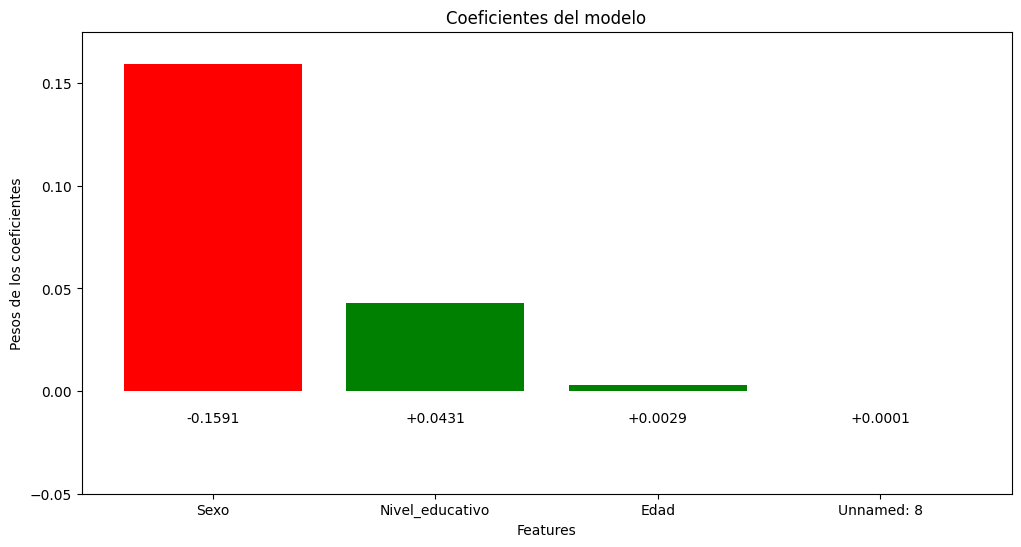

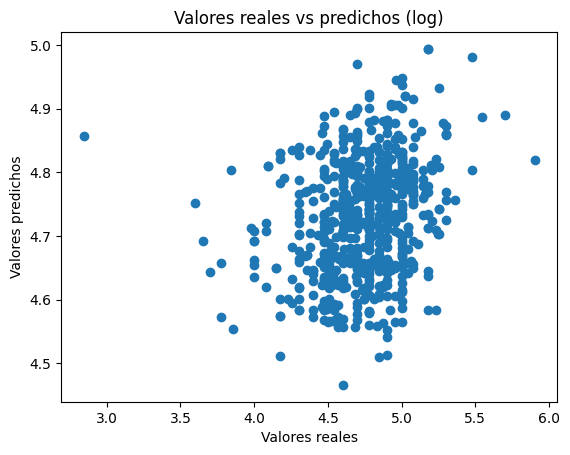

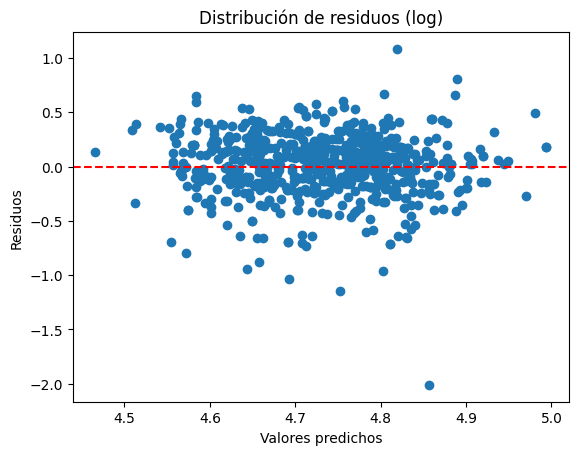

In [ ]:

coef = modelo_1.coef_
features = X.columns

df = pd.DataFrame({
    'Features': features,
    'Coefficient magnitude': modelo_1.coef_
})

# Ordenar el DataFrame por la magnitud de los coeficientes
df = df.reindex(df['Coefficient magnitude'].abs().sort_values(ascending=False).index)

# Graficar los coeficientes
plt.figure(figsize=(12, 6))
bars = plt.bar(df['Features'], df['Coefficient magnitude'].abs(), color=df['Coefficient magnitude'].apply(lambda x: 'green' if x >= 0 else 'red'))
plt.ylabel('Pesos de los coeficientes')
plt.xlabel('Features')
plt.title('Coeficientes del modelo')

# Agregar anotaciones con los valores de los coeficientes debajo de las barras
for idx, bar in enumerate(bars):
    yval = bar.get_height()
    coef_val = df['Coefficient magnitude'].iloc[idx]
    plt.text(bar.get_x() + bar.get_width() / 2, -0.01, f"{coef_val:+.4f}", ha='center', va='top', color='black')

plt.ylim(-0.05, max(df['Coefficient magnitude'].abs()) * 1.1)  # Ajustar el límite inferior del eje y para que las etiquetas se vean bien
plt.show()

plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Valores reales vs predichos (log)')
plt.show()
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Valores predichos')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Distribución de residuos (log)')
plt.show()

### Segundo modelo preguntas menos las regiones y aglomerados

#### Modelo con todas las preguntas menos las regiones y aglomerados

In [ ]:
df_limpio = df_individuos_limpio_primer_trimestre.copy()

varaibles_no_utilzadas_2=['REGION', 'AGLOMERADO',
       'Nivel_más_alto_que_cursa_o_cursó?', '¿Finalizó_1_ese_nivel?',
       'Estado_laboral', 'Categoria_ocupacional',
       "P21",
    ]

for variable in varaibles_no_utilzadas_2:
    if variable in df_limpio.columns:
        del df_limpio[variable]
    else:
        print(variable, "no esta en el dataset")

variables_categoricas=df_limpio.select_dtypes(include=['object']).columns
varaibles_cat=variables_categoricas.tolist()
ohe = OneHotEncoder(handle_unknown='ignore')
df_ohe = ohe.fit_transform(df_limpio[varaibles_cat]).toarray()

feature_names = []
for i, cat in enumerate(ohe.categories_):
    for sub_cat in cat:
        feature_names.append(f"{varaibles_cat[i]}_{sub_cat}")

df_ohe = pd.DataFrame(df_ohe, columns=feature_names)
df_no_cat = df_limpio.drop(columns=varaibles_cat)
df_no_cat.reset_index(drop=True, inplace=True)
df_ohe.reset_index(drop=True, inplace=True)
# Concatena df_no_cat y df_ohe
df_final = pd.concat([df_no_cat, df_ohe], axis=1)

X=df_final.drop(columns='P21_log')
y=df_final['P21_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
modelo_2 = LinearRegression()
modelo_2.fit(X_train, y_train)

# Obtener los coeficientes e el intercept
coefficients = modelo_2.coef_
intercept = modelo_2.intercept_
score = modelo_2.score(X_test, y_test)
coef_df = pd.DataFrame(coefficients, X.columns, columns=['Coefficient'])
coef_df = coef_df.round(8)

intercept_df = pd.DataFrame(data=[intercept], columns=['Intercept'])
y_pred = modelo_2.predict(X_test)
print(f"Model score: {score}")
print("")
print(coef_df)
print("")
print(intercept_df)
print("")
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

AGLOMERADO no esta en el dataset
Model score: 0.3014105844930435

                                                     Coefficient
Unnamed: 8                                          9.017000e-05
Sexo                                               -9.935066e-02
Edad                                                4.000000e-08
¿Sabe_leer_y_escribir?                             -3.836216e-02
Asiste_o_asistió_a_algún_establecimiento_educativo  3.287913e-02
...                                                          ...
caes_seccion_label_SERVICIOS DE ORGANIZACIONES ...  4.748538e-02
caes_seccion_label_SERVICIOS SOCIALES Y DE SALUD   -6.818010e-03
caes_seccion_label_SUMINISTRO DE AGUA; ALCANTAR...  2.409819e-02
caes_seccion_label_SUMINISTRO DE ELECTRICIDAD, ...  3.099360e-01
caes_seccion_label_TRANSPORTE Y ALMACENAMIENTO      4.367376e-02

[82 rows x 1 columns]

   Intercept
0   5.041956

Mean Squared Error: 0.059713976109114324


#### Graficos segundo modelo

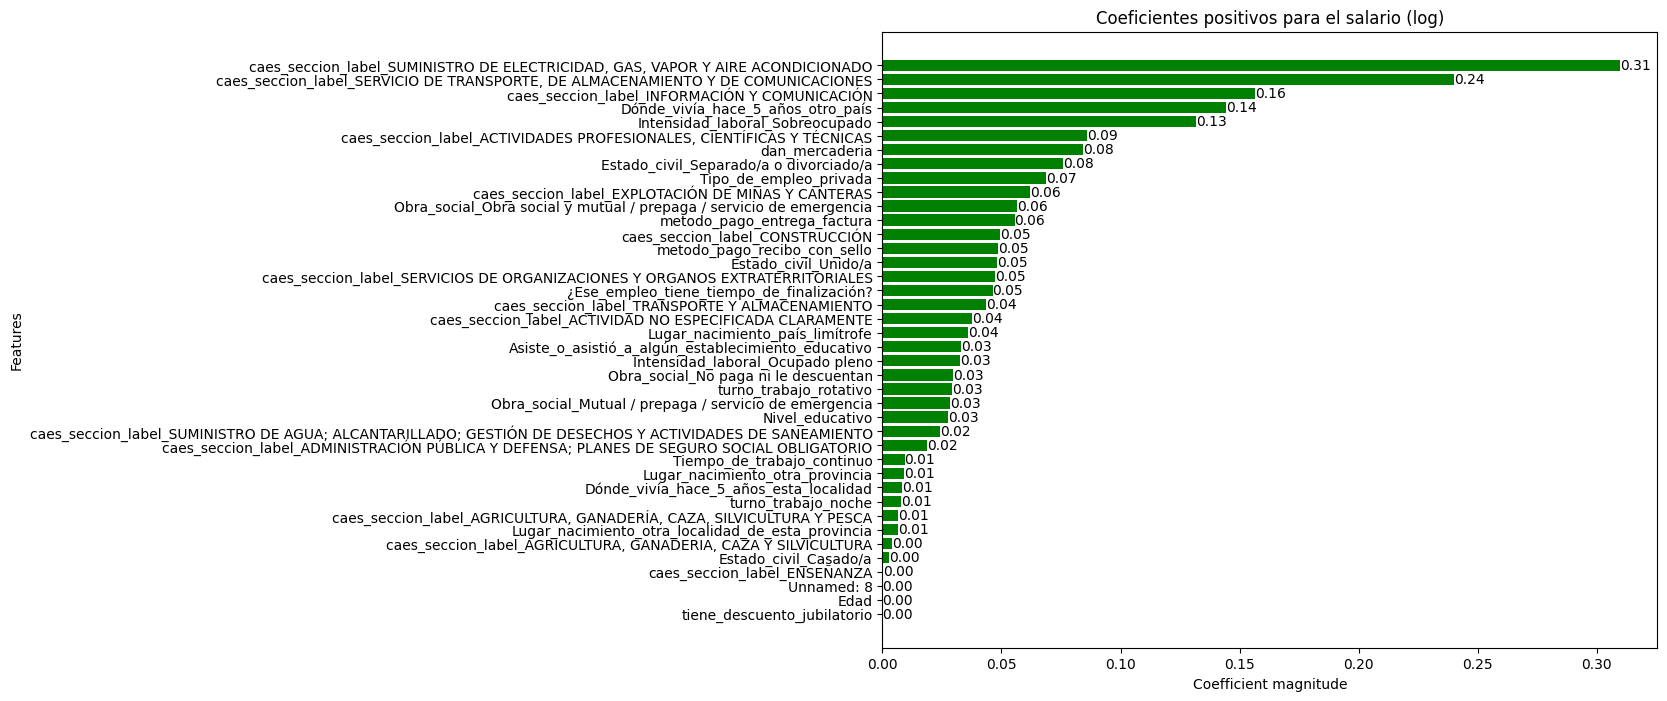

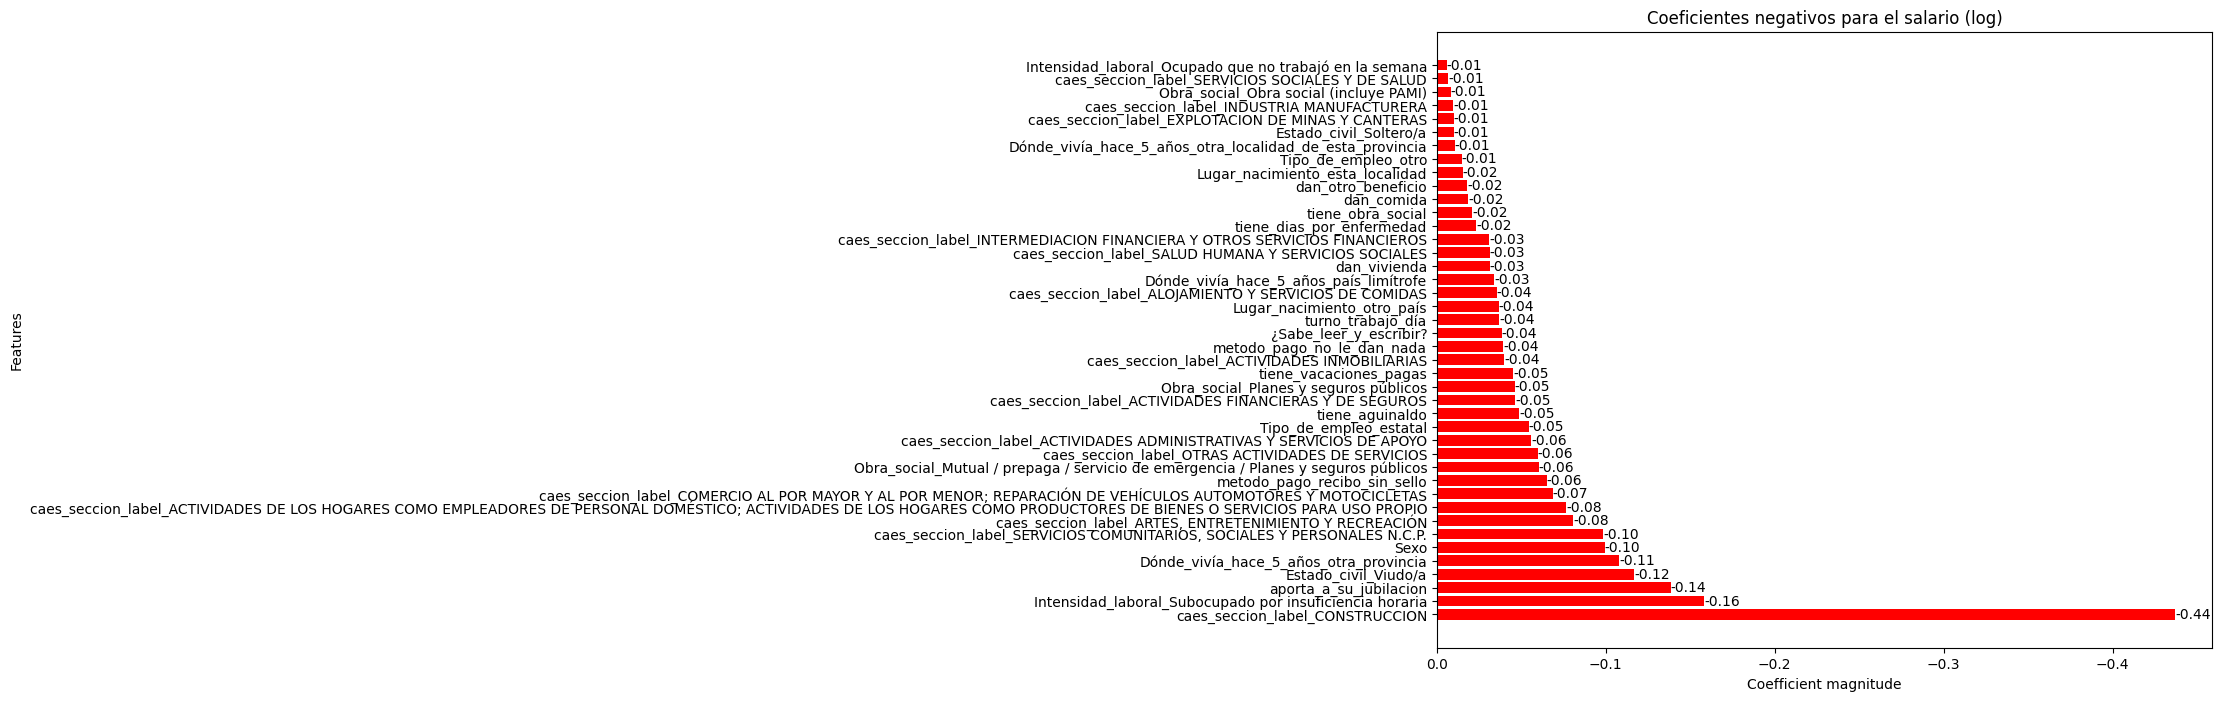

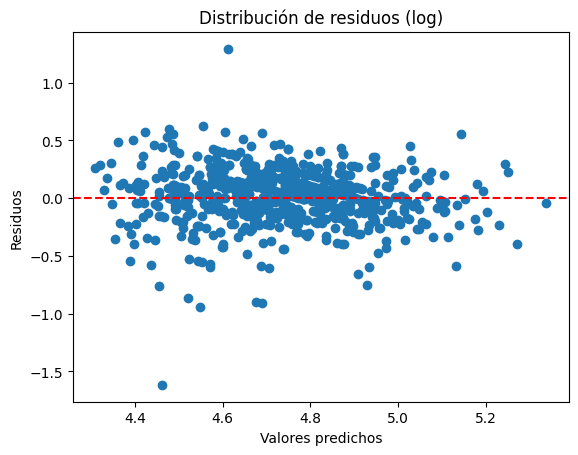

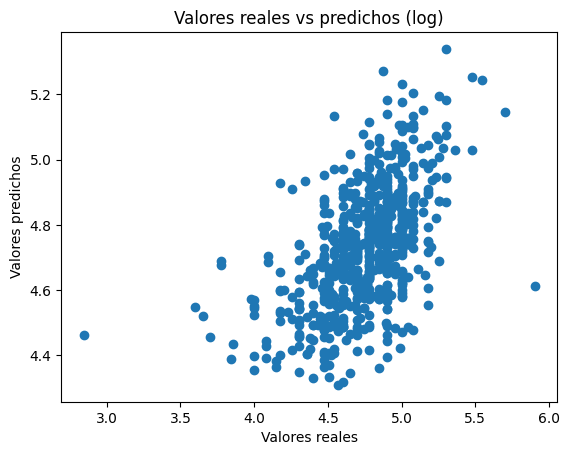

In [ ]:
coef = modelo_2.coef_
features = X.columns

# Separar los coeficientes positivos y negativos
positive_coef = np.array([c if c > 0 else 0 for c in coef])
negative_coef = np.array([c if c < 0 else 0 for c in coef])

# Filtrar los índices de coeficientes positivos y negativos
positive_coef_indices = np.where(positive_coef > 0)[0]
negative_coef_indices = np.where(negative_coef < 0)[0]

# Filtrar las características y coeficientes positivos y negativos
positive_features = features[positive_coef_indices]
positive_values = positive_coef[positive_coef_indices]
negative_features = features[negative_coef_indices]
negative_values = negative_coef[negative_coef_indices]

# Ordenar las características y coeficientes positivos
sorted_positive_indices = np.argsort(positive_values)
sorted_positive_features = positive_features[sorted_positive_indices]
sorted_positive_values = positive_values[sorted_positive_indices]

# Ordenar las características y coeficientes negativos
sorted_negative_indices = np.argsort(negative_values)
sorted_negative_features = negative_features[sorted_negative_indices]
sorted_negative_values = negative_values[sorted_negative_indices]

# Gráfico de barras horizontal para los coeficientes positivos
plt.figure(figsize=(10, 8))
plt.barh(sorted_positive_features, sorted_positive_values, color='green')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes positivos para el salario (log)')

# Agregar anotaciones al comienzo de cada barra
for index, value in enumerate(sorted_positive_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

# Gráfico de barras horizontal para los coeficientes negativos (invertido)
plt.figure(figsize=(10, 8))
plt.barh(sorted_negative_features, sorted_negative_values, color='red')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes negativos para el salario (log)')
plt.gca().invert_xaxis()  # Invertir el eje x

# Agregar anotaciones afuera de cada barra
for index, value in enumerate(sorted_negative_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Valores predichos')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Distribución de residuos (log)')
plt.show()

plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Valores reales vs predichos (log)')
plt.show()


#### Modelo dos con Lasso

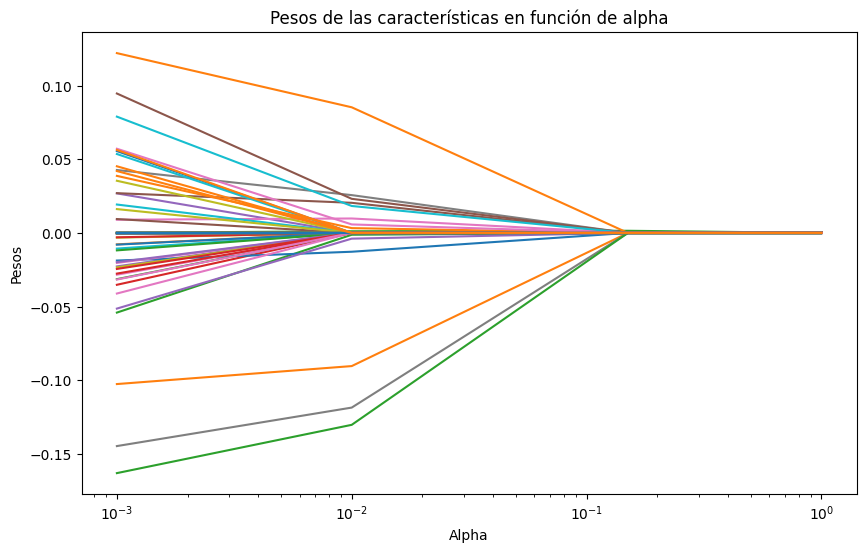

In [ ]:

alphas = [0.001, 0.01, 0.15, 1]
coef_list = []

for alpha in alphas:
    model_2_lasso = LassoCV(cv=5, random_state=42, alphas=[alpha])
    model_2_lasso.fit(X_train, y_train)
    coef_list.append(model_2_lasso.coef_)

# Plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

ax.plot(alphas, coef_list)
ax.set_xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Pesos')
plt.title('Pesos de las características en función de alpha')
plt.axis('tight')
plt.show()

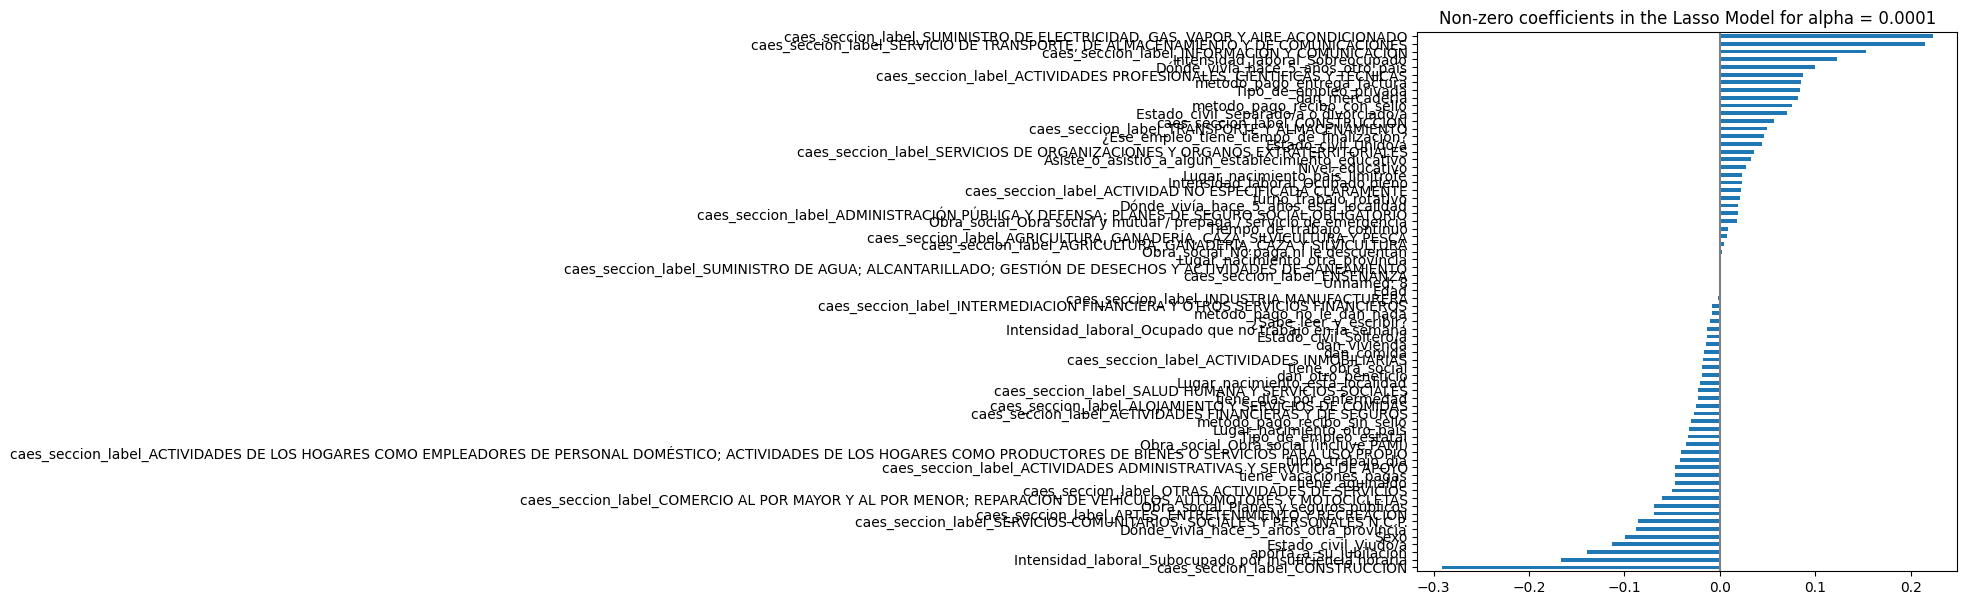

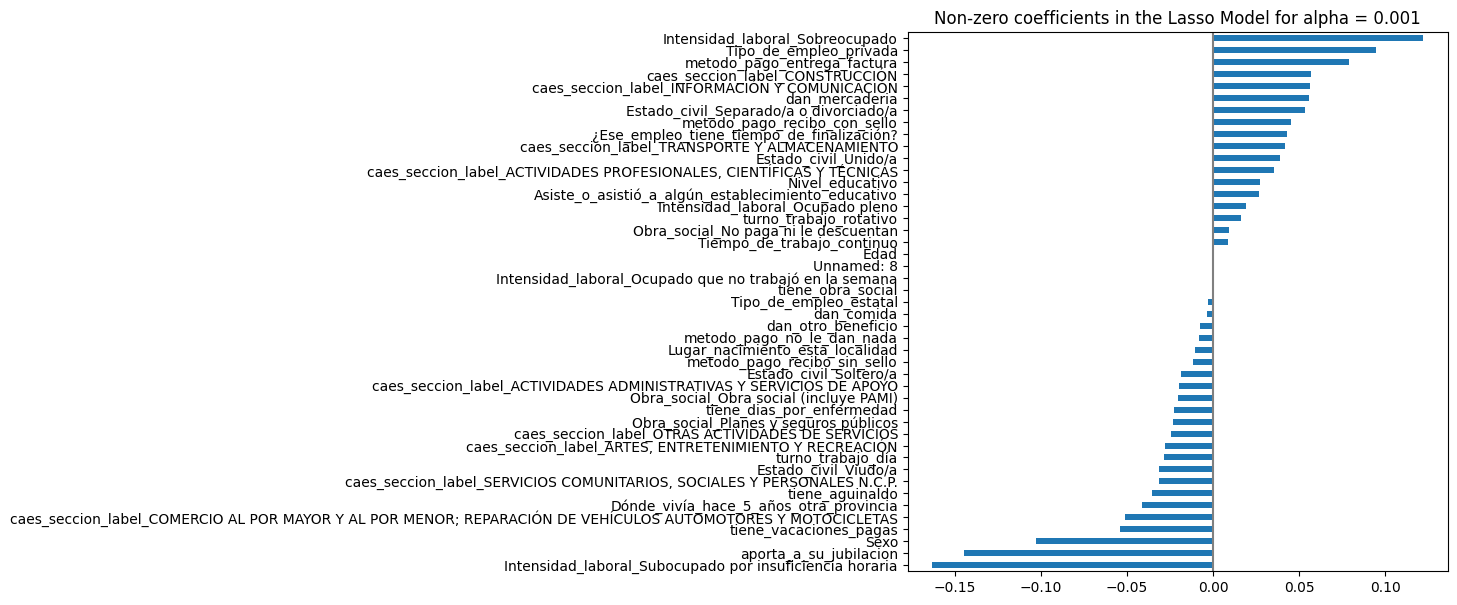

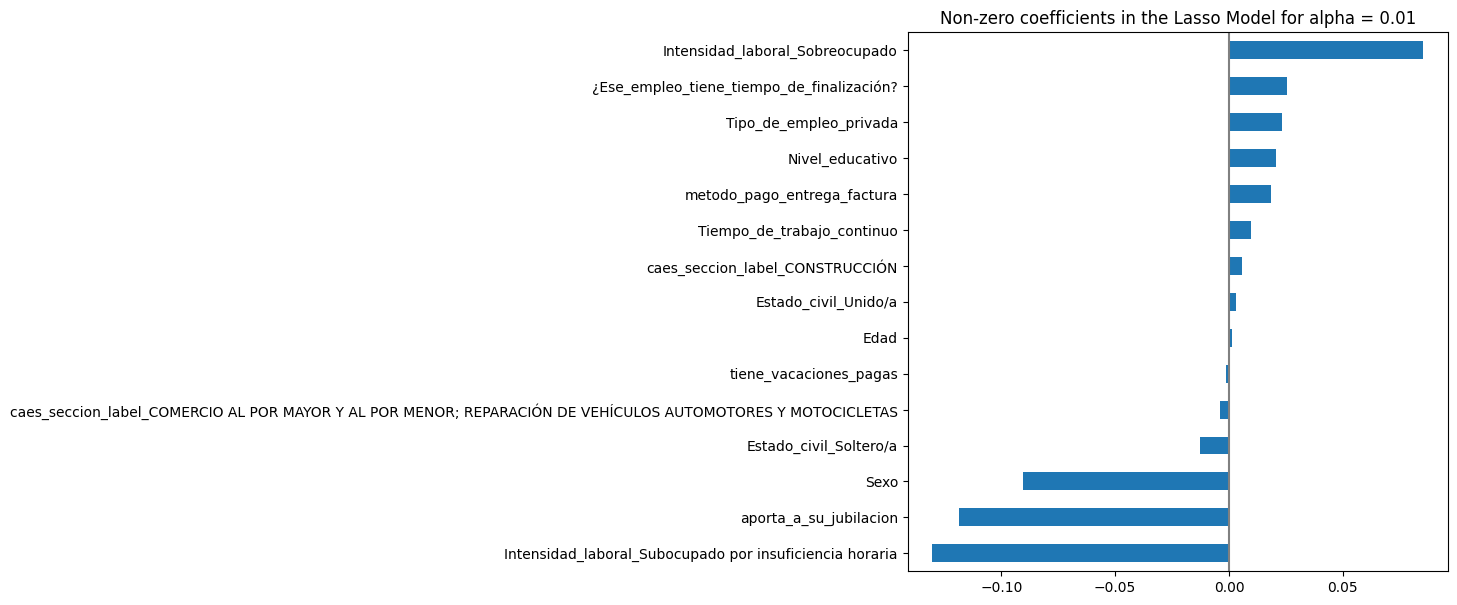

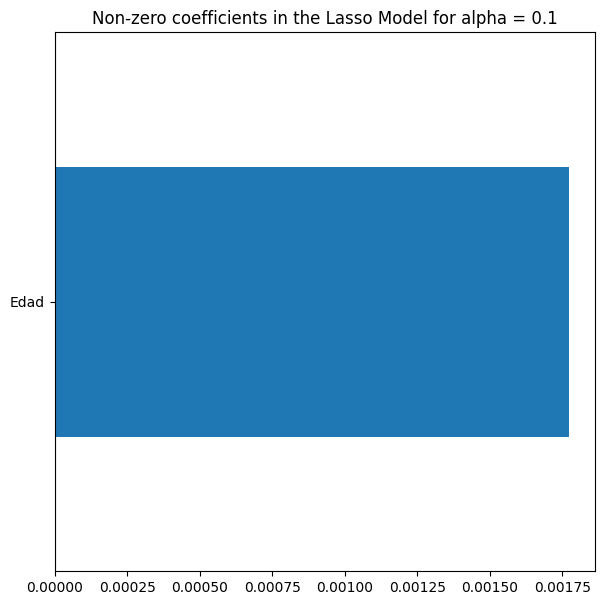

In [ ]:

alphas = [0.0001, 0.001, 0.01, 0.1]

# Initialize a DataFrame to store coefficient values
coef_df = pd.DataFrame()

for alpha in alphas:
    lasso_cv = Lasso(alpha=alpha)
    lasso_cv.fit(X_train, y_train)
    coef_df[str(alpha)] = lasso_cv.coef_

# Set the index of coef_df to be the feature names
coef_df.index = X_train.columns

# Define a tolerance
tol = 1e-5

# Filter out coefficients that are close to zero
coef_df_non_zero = coef_df[np.abs(coef_df) > tol]

# Plot the non-zero coefficients
for column in coef_df_non_zero.columns:
    coef_df_non_zero[column].dropna().sort_values().plot(kind='barh', figsize=(9, 7))
    plt.title(f'Non-zero coefficients in the Lasso Model for alpha = {column}')
    plt.axvline(x=0, color='.5')
    plt.subplots_adjust(left=.3)
    plt.show()


#### LassoCV

In [ ]:
alphas = [0.001, 0.01, 0.1, 1]
alphas = np.linspace(0.001, 1, 1000)
lasso_cv = LassoCV(alphas=alphas, cv=5)  # Use 5-fold cross-validation
lasso_cv.fit(X_train, y_train)
coef_lasso_cv = lasso_cv.coef_
intercept = lasso_cv.intercept_
score = lasso_cv.score(X_test, y_test)
print("Coefficients:")
print(coef_lasso_cv)
best_alpha = lasso_cv.alpha_
print("\nBest alpha:")
print(best_alpha)
print(f"Model score: {score}")
print("")
print(f"Intercept: {intercept}")

Coefficients:
[ 8.56920885e-05 -1.02607675e-01  9.99260292e-05 -0.00000000e+00
  2.68390799e-02  2.69970013e-02  8.96306324e-03  4.27028512e-02
 -3.22792548e-03 -0.00000000e+00  5.55614298e-02 -7.75811688e-03
 -5.40851161e-02 -3.52157280e-02 -2.27182404e-02 -4.32573793e-04
  0.00000000e+00 -1.44713674e-01 -0.00000000e+00  5.35743578e-02
 -1.87568626e-02  3.87210976e-02 -3.13869101e-02  0.00000000e+00
 -0.00000000e+00  9.41898436e-03 -2.03700391e-02  0.00000000e+00
 -2.34130834e-02 -1.06349929e-02  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -4.11506087e-02  0.00000000e+00 -0.00000000e+00  1.92753477e-02
 -2.68119657e-04  1.22062496e-01 -1.63069932e-01 -2.97808037e-03
 -0.00000000e+00  9.46474307e-02 -2.83575546e-02 -0.00000000e+00
  1.61739813e-02  7.89409022e-02 -7.95885535e-03  4.52440534e-02
 -1.18509763e-02  0.00000000e+00 -1.98299673e-02 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  3.54088153e-02  0.00000000e+00
  0.0000000

#### Graficos LassoCV

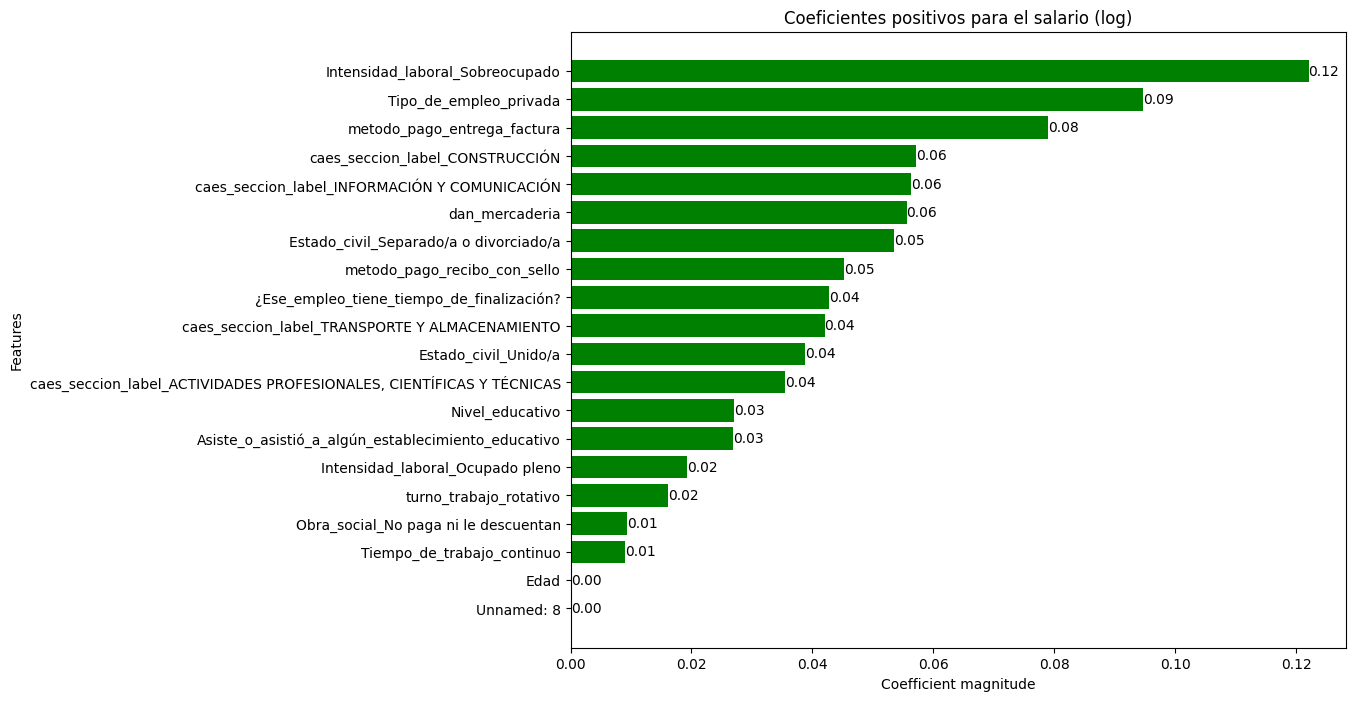

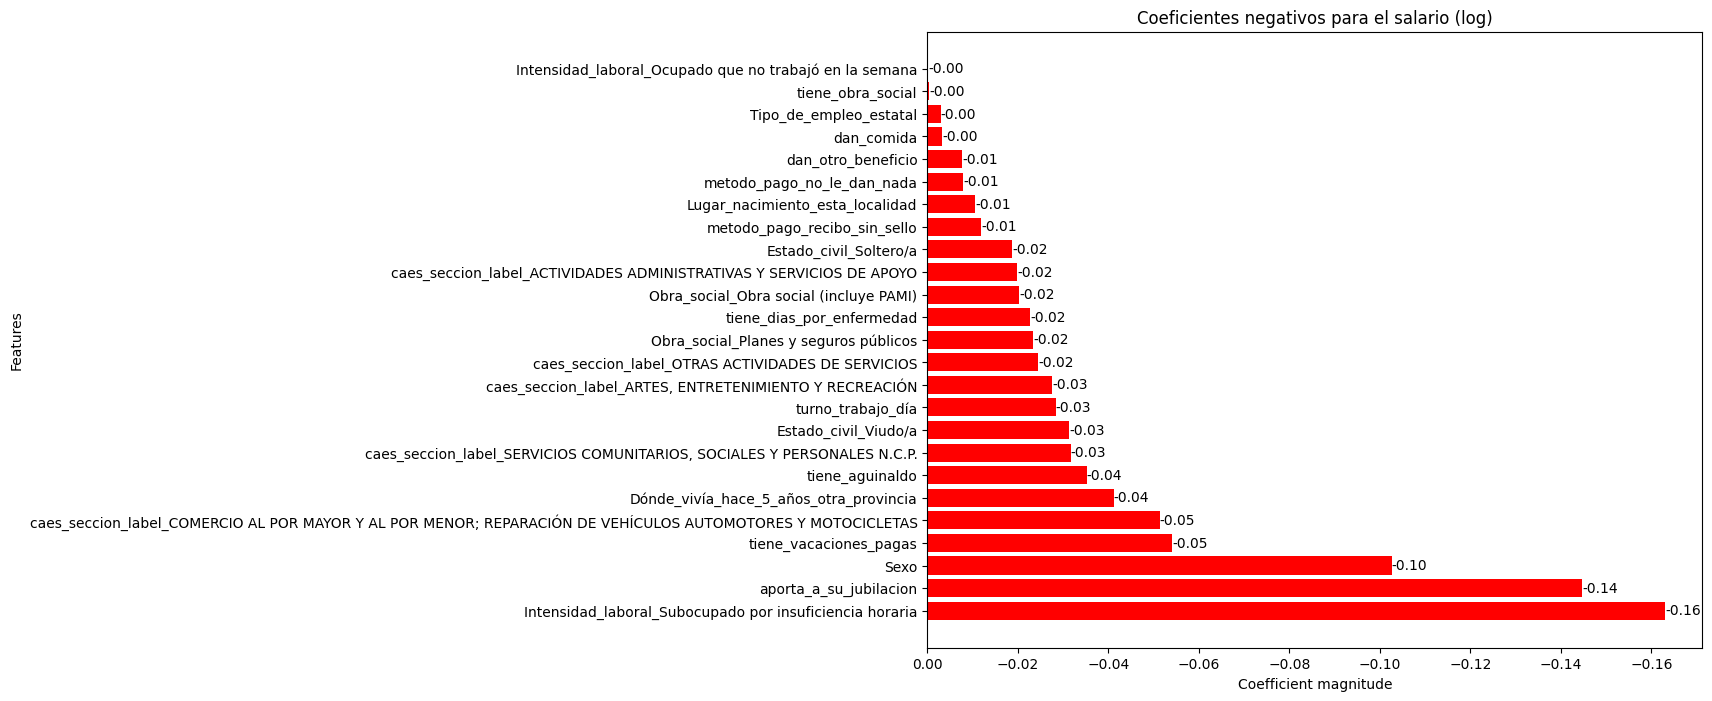

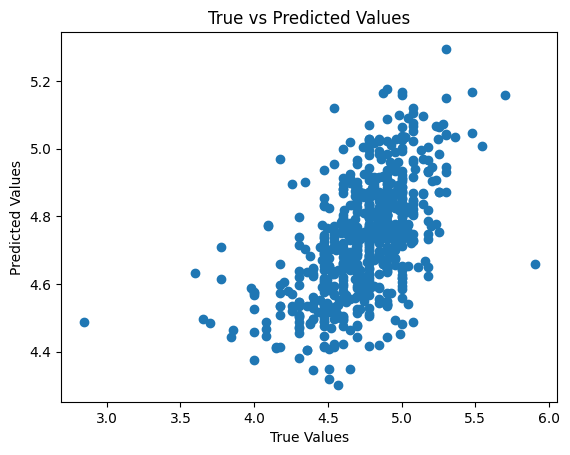

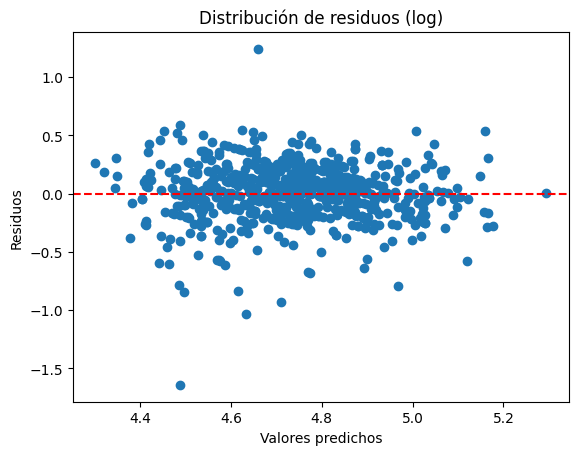

In [ ]:
coef = lasso_cv.coef_
features = X.columns

# Separar los coeficientes positivos y negativos
positive_coef = np.array([c if c > 0 else 0 for c in coef])
negative_coef = np.array([c if c < 0 else 0 for c in coef])

# Filtrar los índices de coeficientes positivos y negativos
positive_coef_indices = np.where(positive_coef > 0)[0]
negative_coef_indices = np.where(negative_coef < 0)[0]

# Filtrar las características y coeficientes positivos y negativos
positive_features = features[positive_coef_indices]
positive_values = positive_coef[positive_coef_indices]
negative_features = features[negative_coef_indices]
negative_values = negative_coef[negative_coef_indices]

# Ordenar las características y coeficientes positivos
sorted_positive_indices = np.argsort(positive_values)
sorted_positive_features = positive_features[sorted_positive_indices]
sorted_positive_values = positive_values[sorted_positive_indices]

# Ordenar las características y coeficientes negativos
sorted_negative_indices = np.argsort(negative_values)
sorted_negative_features = negative_features[sorted_negative_indices]
sorted_negative_values = negative_values[sorted_negative_indices]

# Gráfico de barras horizontal para los coeficientes positivos
plt.figure(figsize=(10, 8))
plt.barh(sorted_positive_features, sorted_positive_values, color='green')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes positivos para el salario (log)')

# Agregar anotaciones al comienzo de cada barra
for index, value in enumerate(sorted_positive_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

# Gráfico de barras horizontal para los coeficientes negativos (invertido)
plt.figure(figsize=(10, 8))
plt.barh(sorted_negative_features, sorted_negative_values, color='red')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes negativos para el salario (log)')
plt.gca().invert_xaxis()  # Invertir el eje x

# Agregar anotaciones afuera de cada barra
for index, value in enumerate(sorted_negative_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()
y_pred = lasso_cv.predict(X_test)
plt.scatter(y_test, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.show()

residuals = y_test - y_pred

plt.scatter(y_pred, residuals)
plt.xlabel('Valores predichos')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Distribución de residuos (log)')
plt.show()

### Tercer Modelo con region y tipo de trabajo

In [ ]:
df_limpio = df_individuos_limpio_primer_trimestre.copy()

varaibles_no_utilzadas_3=['AGLOMERADO',
       'Nivel_más_alto_que_cursa_o_cursó?', '¿Finalizó_1_ese_nivel?',
       'Estado_laboral', 'Categoria_ocupacional', "P21"]

for variable in varaibles_no_utilzadas_3:
    if variable in df_limpio.columns:
        del df_limpio[variable]
    else:
        print(variable, "no esta en el dataset")


variables_categoricas=df_limpio.select_dtypes(include=['object']).columns
varaibles_cat=variables_categoricas.tolist()
ohe = OneHotEncoder(handle_unknown='ignore')
df_ohe = ohe.fit_transform(df_limpio[varaibles_cat]).toarray()

feature_names = []
for i, cat in enumerate(ohe.categories_):
    for sub_cat in cat:
        feature_names.append(f"{varaibles_cat[i]}_{sub_cat}")

df_ohe = pd.DataFrame(df_ohe, columns=feature_names)


df_no_cat = df_limpio.drop(columns=varaibles_cat)
df_no_cat.reset_index(drop=True, inplace=True)
df_ohe.reset_index(drop=True, inplace=True)
df_final = pd.concat([df_no_cat, df_ohe], axis=1)


X=df_final.drop(columns='P21_log')
y=df_final['P21_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = np.linspace(0.001, 1, 1000)
modelo_3 = LassoCV(cv=5, random_state=42, alphas=alphas)
modelo_3.fit(X_train, y_train)
# Obtener los coeficientes e el intercept
coefficients = modelo_3.coef_
intercept = modelo_3.intercept_
score = modelo_3.score(X_test, y_test)
coef_df = pd.DataFrame(coefficients, X.columns, columns=['Coefficient'])
coef_df = coef_df.round(8)
intercept_df = pd.DataFrame(data=[intercept], columns=['Intercept'])
y_pred = modelo_3.predict(X_test)
best_alpha = modelo_3.alpha_
print(f"Best alpha: {best_alpha}")
print(f"Model score: {score}")
print("")
print(coef_df)
print("")
print(intercept_df)
print("")
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))


AGLOMERADO no esta en el dataset
Best alpha: 0.001
Model score: 0.32465242632457003

                                                    Coefficient
Unnamed: 8                                            -0.000180
Sexo                                                  -0.101722
Edad                                                   0.000153
¿Sabe_leer_y_escribir?                                -0.000000
Asiste_o_asistió_a_algún_establecimiento_educativo     0.029378
...                                                         ...
caes_seccion_label_SERVICIOS DE ORGANIZACIONES ...     0.000000
caes_seccion_label_SERVICIOS SOCIALES Y DE SALUD       0.000000
caes_seccion_label_SUMINISTRO DE AGUA; ALCANTAR...     0.000000
caes_seccion_label_SUMINISTRO DE ELECTRICIDAD, ...     0.000000
caes_seccion_label_TRANSPORTE Y ALMACENAMIENTO         0.038349

[88 rows x 1 columns]

   Intercept
0   4.946489

Mean Squared Error: 0.05772731161484563


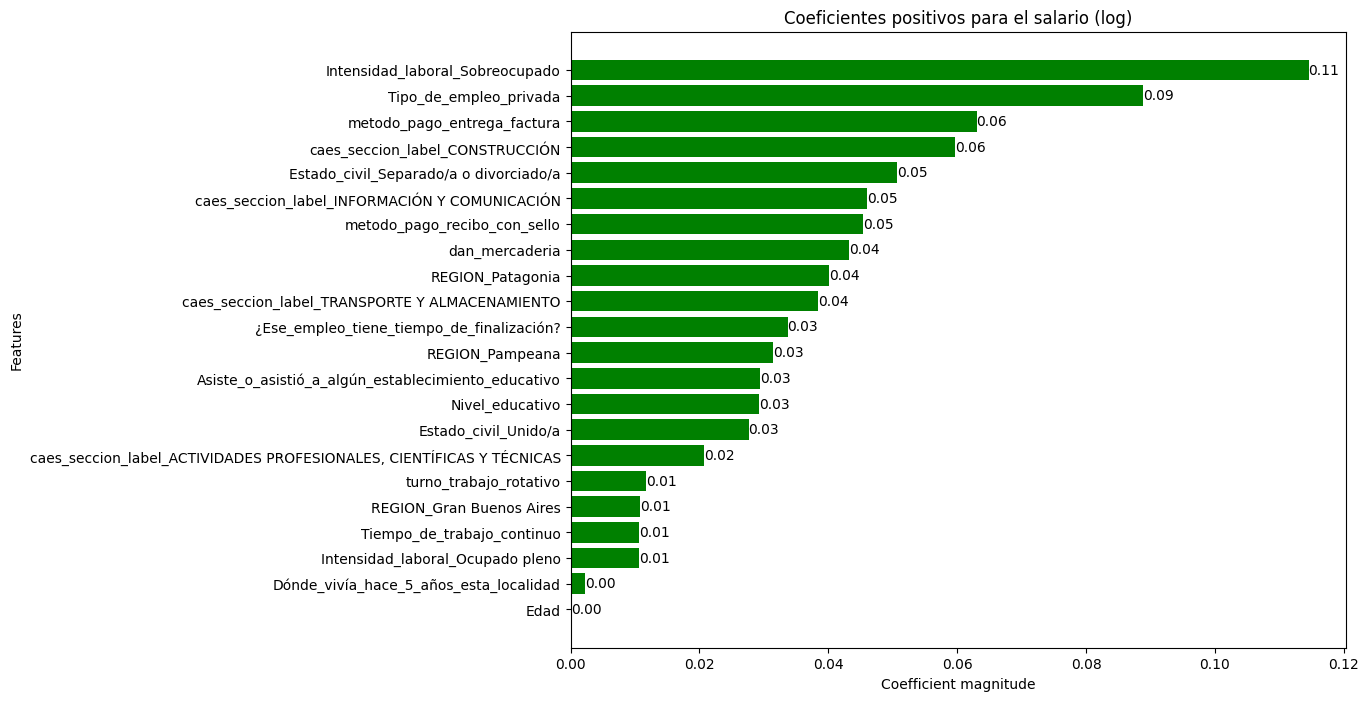

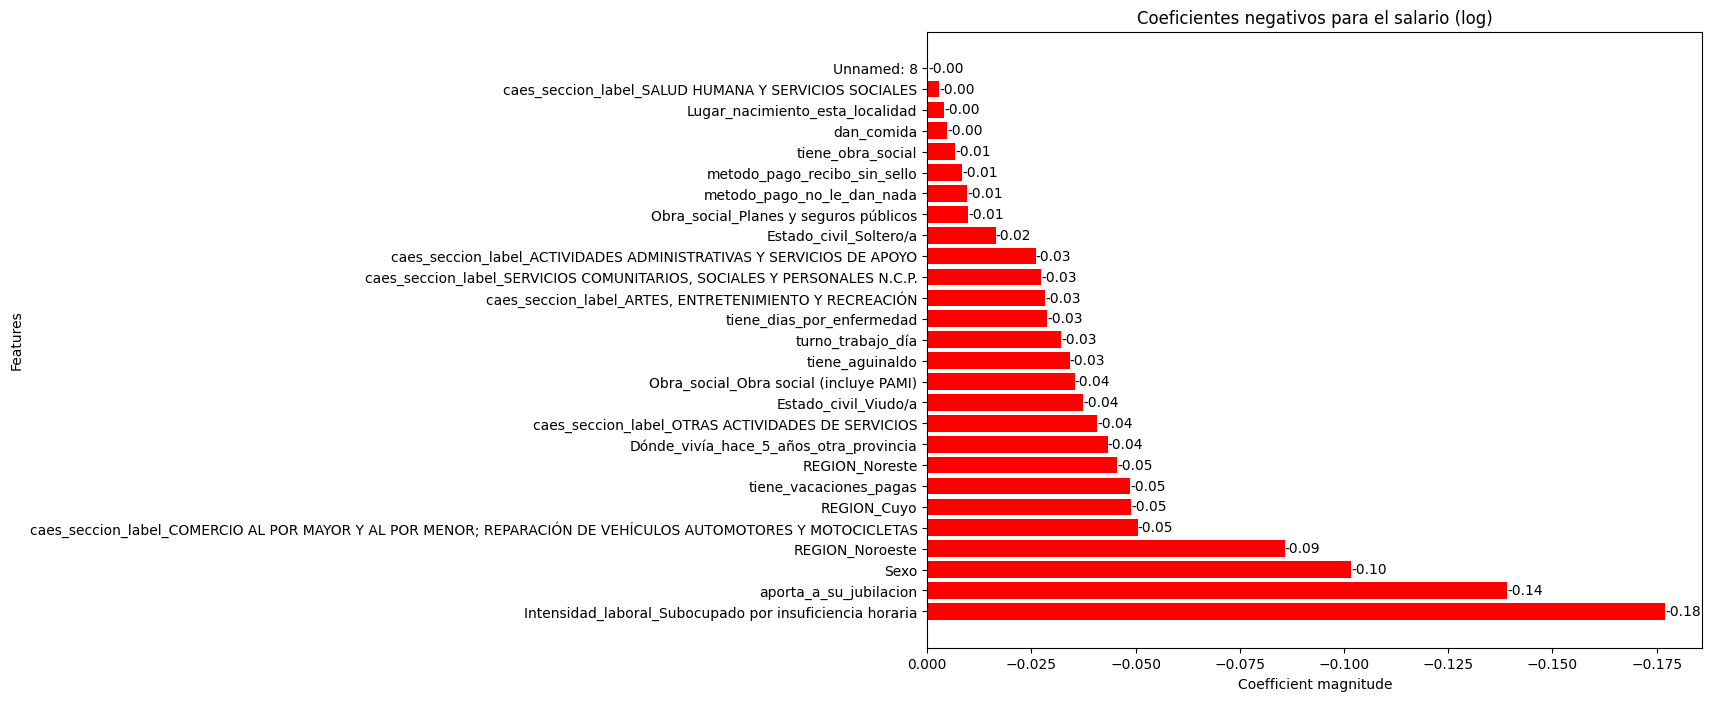

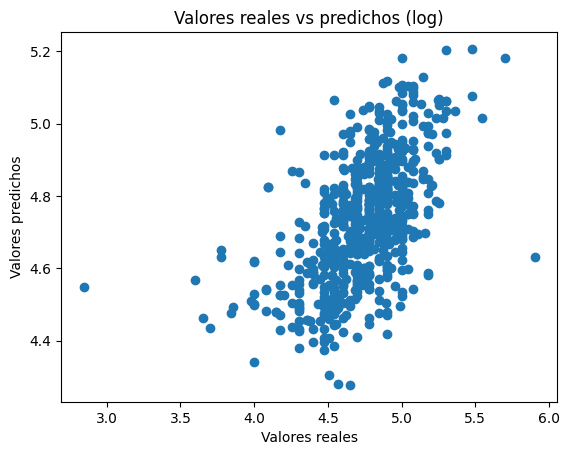

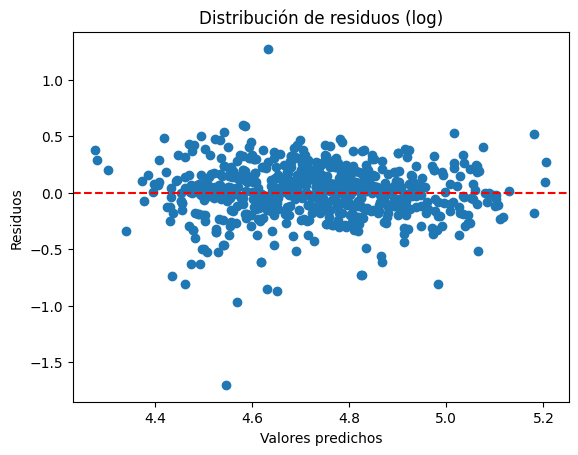

In [ ]:

coef = modelo_3.coef_
features = X.columns

# Separar los coeficientes positivos y negativos
positive_coef = np.array([c if c > 0 else 0 for c in coef])
negative_coef = np.array([c if c < 0 else 0 for c in coef])

# Filtrar los índices de coeficientes positivos y negativos
positive_coef_indices = np.where(positive_coef > 0)[0]
negative_coef_indices = np.where(negative_coef < 0)[0]

# Filtrar las características y coeficientes positivos y negativos
positive_features = features[positive_coef_indices]
positive_values = positive_coef[positive_coef_indices]
negative_features = features[negative_coef_indices]
negative_values = negative_coef[negative_coef_indices]

# Ordenar las características y coeficientes positivos
sorted_positive_indices = np.argsort(positive_values)
sorted_positive_features = positive_features[sorted_positive_indices]
sorted_positive_values = positive_values[sorted_positive_indices]

# Ordenar las características y coeficientes negativos
sorted_negative_indices = np.argsort(negative_values)
sorted_negative_features = negative_features[sorted_negative_indices]
sorted_negative_values = negative_values[sorted_negative_indices]

# Gráfico de barras horizontal para los coeficientes positivos
plt.figure(figsize=(10, 8))
plt.barh(sorted_positive_features, sorted_positive_values, color='green')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes positivos para el salario (log)')

# Agregar anotaciones al comienzo de cada barra
for index, value in enumerate(sorted_positive_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

# Gráfico de barras horizontal para los coeficientes negativos (invertido)
plt.figure(figsize=(10, 8))
plt.barh(sorted_negative_features, sorted_negative_values, color='red')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes negativos para el salario (log)')
plt.gca().invert_xaxis()  # Invertir el eje x

# Agregar anotaciones afuera de cada barra
for index, value in enumerate(sorted_negative_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

plt.scatter(y_test, y_pred)
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Valores reales vs predichos (log)')
plt.show()
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Valores predichos')
plt.ylabel('Residuos')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Distribución de residuos (log)')
plt.show()




### Modelos por regiones y aglomerado


In [ ]:
df_limpio_4 = df_individuos_limpio_primer_trimestre.copy()

df_cuyo = df_limpio_4[df_limpio_4['REGION'] == 'Cuyo']
df_gba = df_limpio_4[df_limpio_4['REGION'] == 'Gran Buenos Aires']
df_patagonico = df_limpio_4[df_limpio_4['REGION'] == 'Patagonia']
df_noroeste = df_limpio_4[df_limpio_4['REGION'] == 'Noroeste']
df_noreste = df_limpio_4[df_limpio_4['REGION'] == 'Noreste']
df_pampeano = df_limpio_4[df_limpio_4['REGION'] == 'Pampeana']

#### Noroeste

Coefficients:
[ 9.09253752e-03 -5.65145524e-02  8.99341102e-04 -0.00000000e+00
  0.00000000e+00 -3.74460803e-02  2.93683578e-02 -7.98471573e-03
  1.01041138e-01 -0.00000000e+00  0.00000000e+00  2.47224683e-02
  0.00000000e+00 -3.26248722e-02 -2.10181601e-02 -1.00906462e-02
  5.08819270e-02  0.00000000e+00 -2.45119161e-02  0.00000000e+00
  8.74461224e-03 -0.00000000e+00 -1.01368548e-02  4.94152733e-02
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.73282433e-02  0.00000000e+00 -3.35502150e-02
  4.11832258e-03 -0.00000000e+00 -8.11036349e-04  9.72426037e-02
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -5.47994256e-01  0.00000000e+00  0.00000000e+00 -2.61378785e-04
  5.16838143e-02  7.12002412e-02 -1.64497121e-01 -4.20470369e-02
 -0.00000000e+00  8.81999489e-02  1.14884427e-02 -5.25050019e-03
  0.00000000e+00  6.02899650e-02 -0.00000000e+00  0.00000000e+00
 -2.12404699e-02 -0.00000000e+00 -1.99779736e-01  0.00000000e+00
  0.0000000

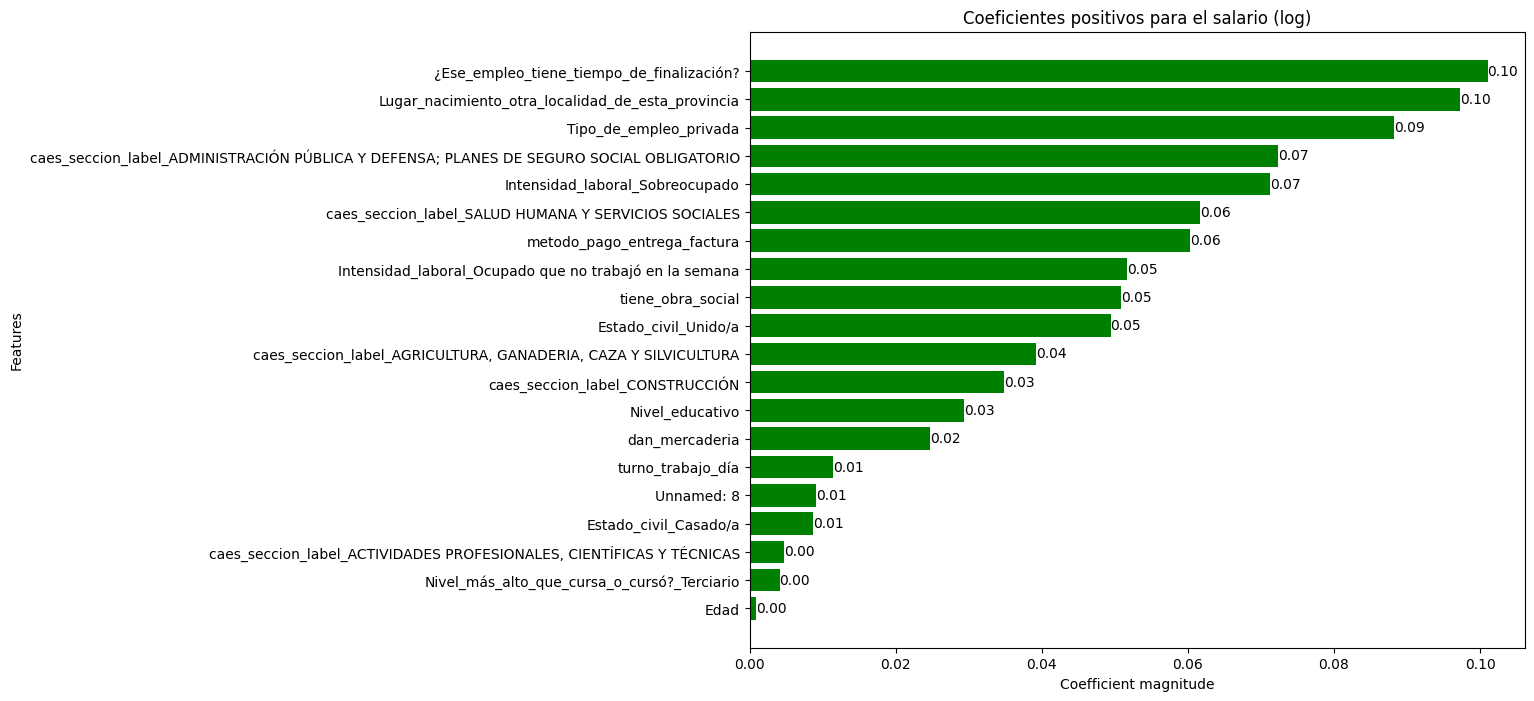

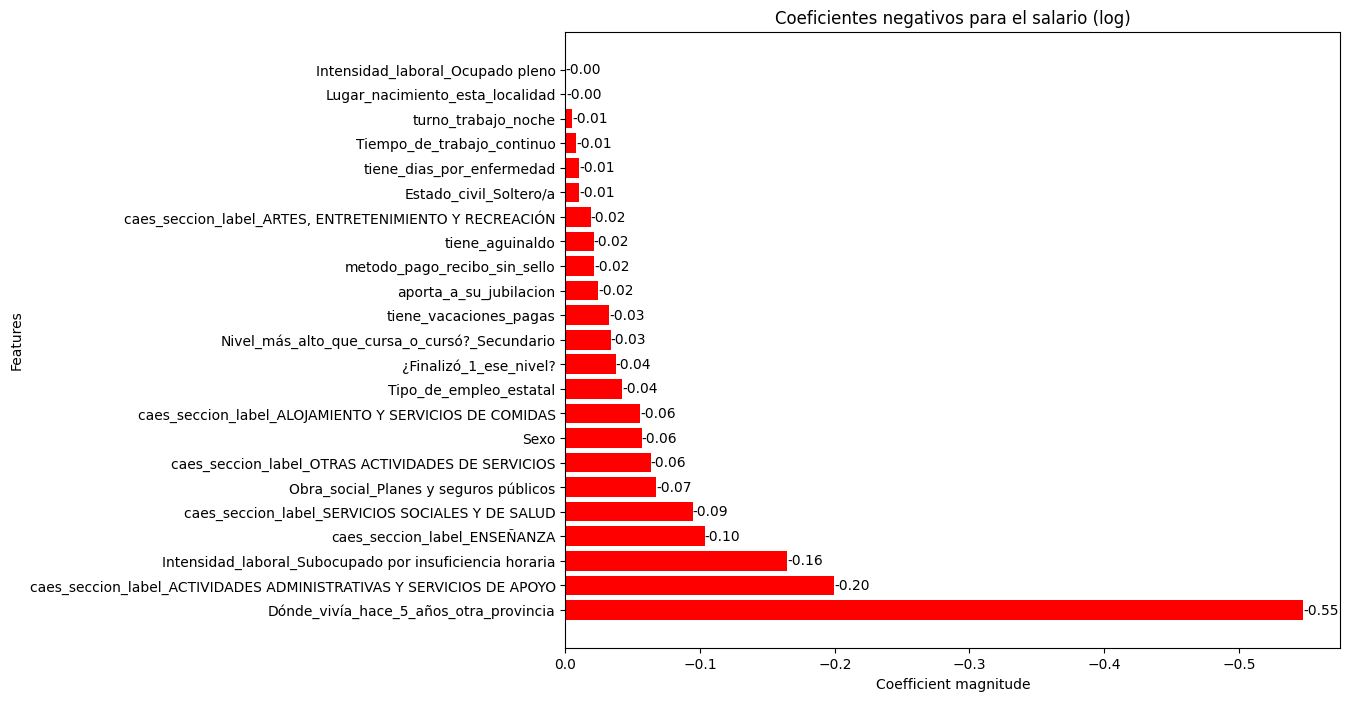

In [ ]:
varaibles_no_utilzadas_4=["P21"]

for variable in varaibles_no_utilzadas_4:
    if variable in df_noreste.columns:
        del df_noreste[variable]
    else:
        print(variable, "no esta en el dataset")


variables_categoricas=df_noreste.select_dtypes(include=['object']).columns
varaibles_cat=variables_categoricas.tolist()
ohe = OneHotEncoder(handle_unknown='ignore')
df_ohe = ohe.fit_transform(df_noreste[varaibles_cat]).toarray()

feature_names = []
for i, cat in enumerate(ohe.categories_):
    for sub_cat in cat:
        feature_names.append(f"{varaibles_cat[i]}_{sub_cat}")

df_ohe = pd.DataFrame(df_ohe, columns=feature_names)


df_no_cat = df_noreste.drop(columns=varaibles_cat)
df_no_cat.reset_index(drop=True, inplace=True)
df_ohe.reset_index(drop=True, inplace=True)
# Concatena df_no_cat y df_ohe
df_final = pd.concat([df_no_cat, df_ohe], axis=1)

X=df_final.drop(columns='P21_log')
y=df_final['P21_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = np.linspace(0.001, 1, 1)
lasso_cv = LassoCV(alphas=alphas, cv=5)  # Use 5-fold cross-validation
lasso_cv.fit(X_train, y_train)

# Get the coefficients
coef_lasso_cv = lasso_cv.coef_
intercept = lasso_cv.intercept_
score = lasso_cv.score(X_test, y_test)
# Print the coefficients
print("Coefficients:")
print(coef_lasso_cv)

# Get the best alpha
best_alpha = lasso_cv.alpha_

# Print the best alpha
print("\nBest alpha:")
print(best_alpha)
print(f"Model score: {score}")
print("")
print(f"Intercept: {intercept}")
y_pred = lasso_cv.predict(X_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))



coef = lasso_cv.coef_
features = X.columns

# Separar los coeficientes positivos y negativos
positive_coef = np.array([c if c > 0 else 0 for c in coef])
negative_coef = np.array([c if c < 0 else 0 for c in coef])

# Filtrar los índices de coeficientes positivos y negativos
positive_coef_indices = np.where(positive_coef > 0)[0]
negative_coef_indices = np.where(negative_coef < 0)[0]

# Filtrar las características y coeficientes positivos y negativos
positive_features = features[positive_coef_indices]
positive_values = positive_coef[positive_coef_indices]
negative_features = features[negative_coef_indices]
negative_values = negative_coef[negative_coef_indices]

# Ordenar las características y coeficientes positivos
sorted_positive_indices = np.argsort(positive_values)
sorted_positive_features = positive_features[sorted_positive_indices]
sorted_positive_values = positive_values[sorted_positive_indices]

# Ordenar las características y coeficientes negativos
sorted_negative_indices = np.argsort(negative_values)
sorted_negative_features = negative_features[sorted_negative_indices]
sorted_negative_values = negative_values[sorted_negative_indices]

# Gráfico de barras horizontal para los coeficientes positivos
plt.figure(figsize=(10, 8))
plt.barh(sorted_positive_features, sorted_positive_values, color='green')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes positivos para el salario (log)')

# Agregar anotaciones al comienzo de cada barra
for index, value in enumerate(sorted_positive_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

# Gráfico de barras horizontal para los coeficientes negativos (invertido)
plt.figure(figsize=(10, 8))
plt.barh(sorted_negative_features, sorted_negative_values, color='red')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes negativos para el salario (log)')
plt.gca().invert_xaxis()  # Invertir el eje x

# Agregar anotaciones afuera de cada barra
for index, value in enumerate(sorted_negative_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

#### Pampeana

Coefficients:
[ 1.59275363e-04 -8.67141433e-02  4.24341294e-04  0.00000000e+00
  3.54112690e-02 -0.00000000e+00  2.96353064e-02  2.24176738e-02
  0.00000000e+00  2.57859121e-02  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -1.17511395e-02 -7.00755879e-02 -0.00000000e+00
 -8.87339569e-03  0.00000000e+00 -3.05582161e-02  0.00000000e+00
 -0.00000000e+00  4.48423795e-02 -3.78595825e-02  0.00000000e+00
 -0.00000000e+00 -1.59754988e-03  3.93778697e-02  0.00000000e+00
  6.63198171e-03 -1.02816225e-01 -0.00000000e+00  3.00765383e-03
  8.30527895e-03 -1.10692766e-02 -0.00000000e+00 -0.00000000e+00
  7.29471264e-03 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  2.30589158e-02 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  2.72565583e-02
 -0.00000000e+00  1.28786237e-01 -1.77534345e-01  0.00000000e+00
 -6.65055177e-02  4.67513285e-02 -2.25057500e-02  0.00000000e+00
  3.92434587e-02  1.08540145e-01 -5.23012158e-02 -0.00000000e+00
  0.0000000

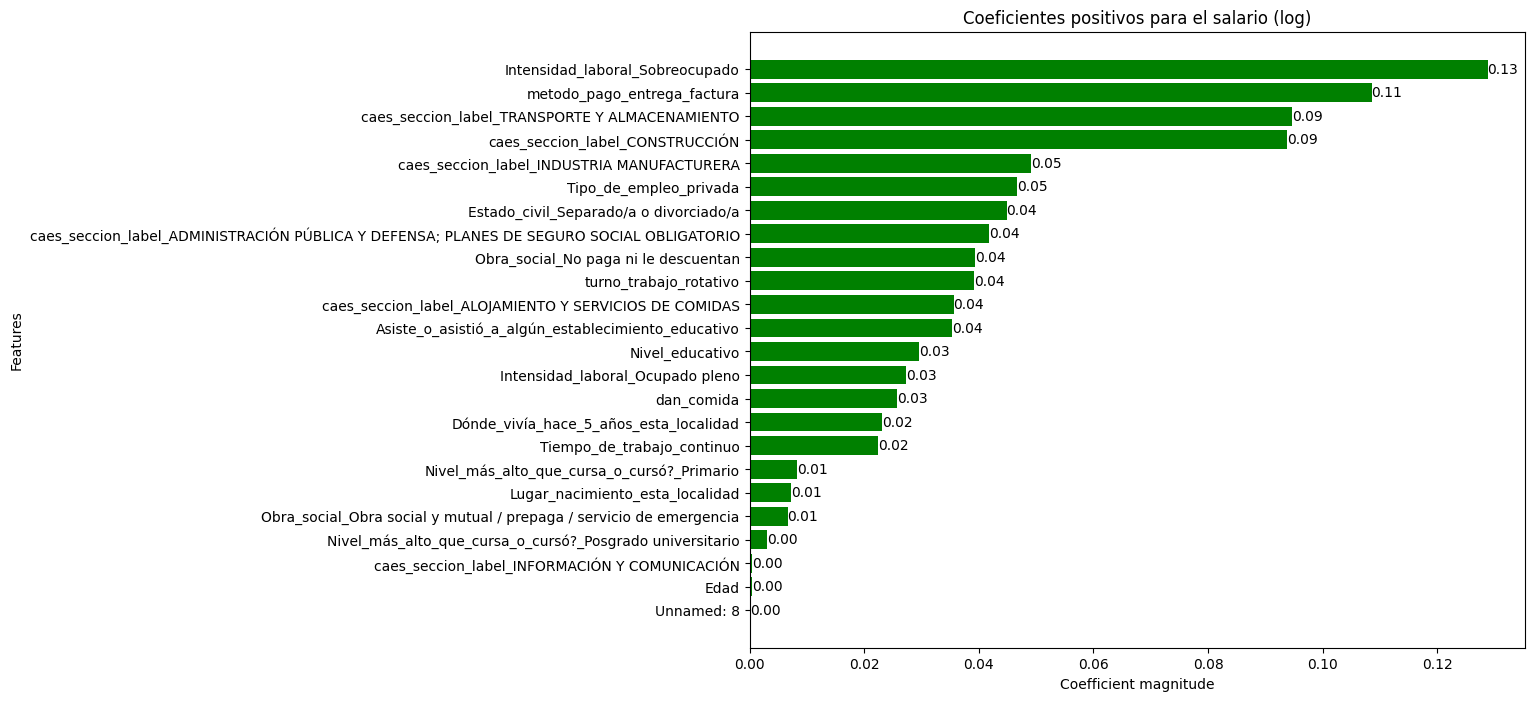

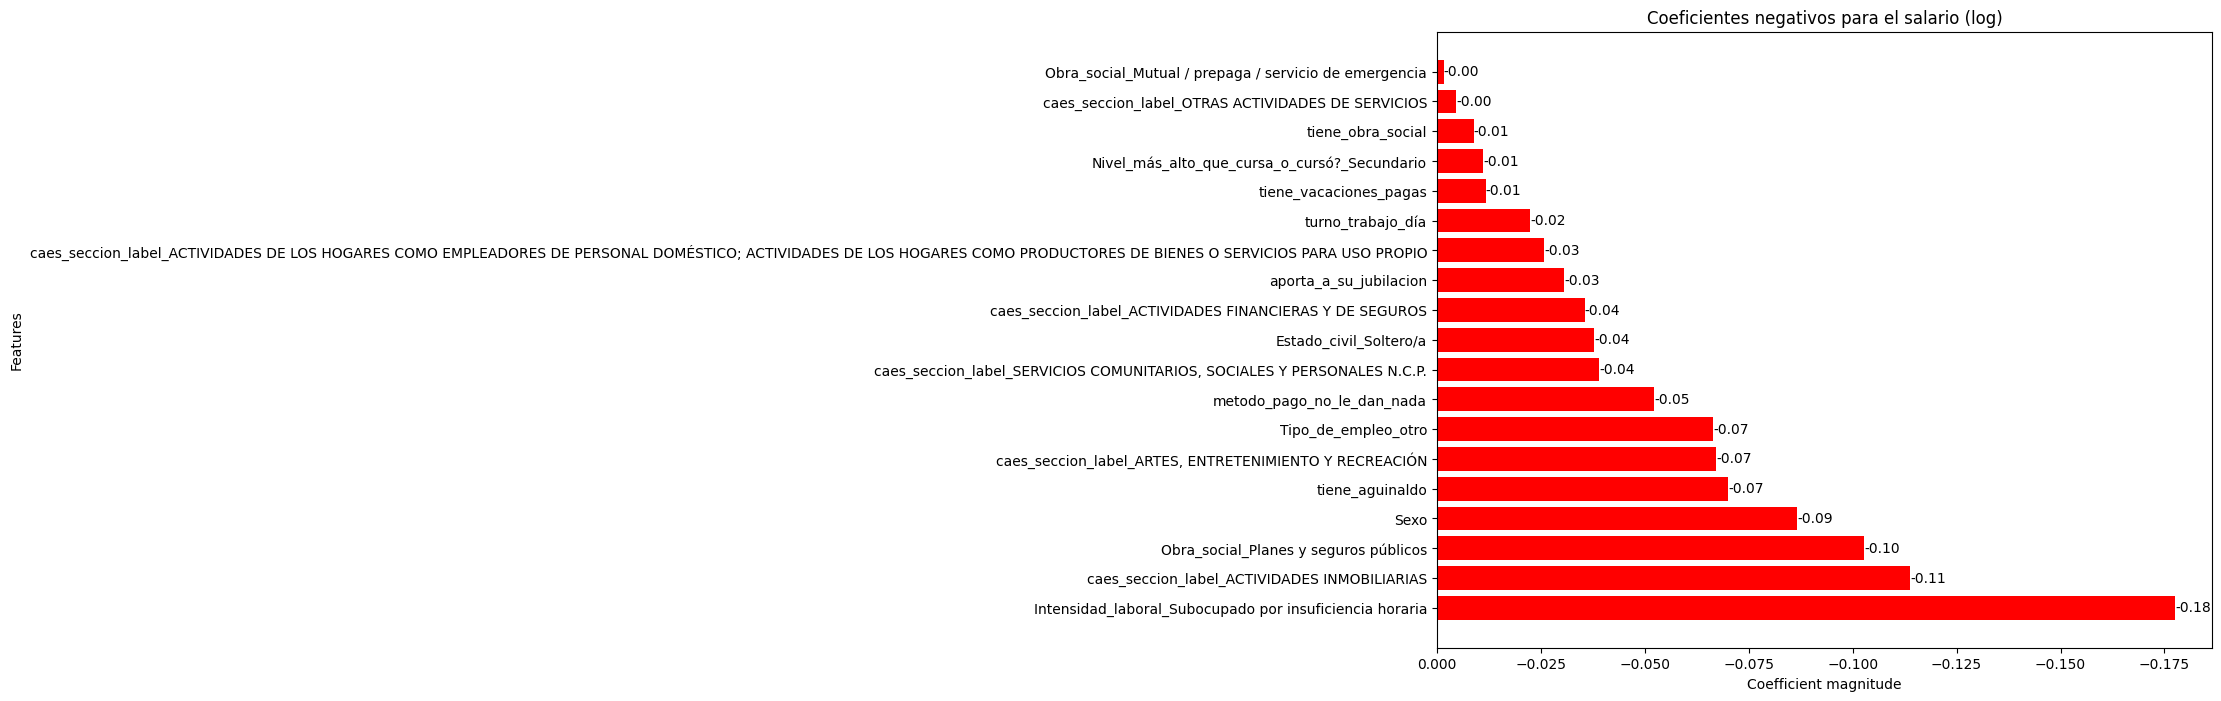

In [ ]:
varaibles_no_utilzadas_4=["P21"]

for variable in varaibles_no_utilzadas_4:
    if variable in df_pampeano.columns:
        del df_pampeano[variable]
    else:
        print(variable, "no esta en el dataset")


variables_categoricas=df_pampeano.select_dtypes(include=['object']).columns
varaibles_cat=variables_categoricas.tolist()
ohe = OneHotEncoder(handle_unknown='ignore')
df_ohe = ohe.fit_transform(df_pampeano[varaibles_cat]).toarray()

feature_names = []
for i, cat in enumerate(ohe.categories_):
    for sub_cat in cat:
        feature_names.append(f"{varaibles_cat[i]}_{sub_cat}")

df_ohe = pd.DataFrame(df_ohe, columns=feature_names)


df_no_cat = df_pampeano.drop(columns=varaibles_cat)
df_no_cat.reset_index(drop=True, inplace=True)
df_ohe.reset_index(drop=True, inplace=True)
# Concatena df_no_cat y df_ohe
df_final = pd.concat([df_no_cat, df_ohe], axis=1)

X=df_final.drop(columns='P21_log')
y=df_final['P21_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = np.linspace(0.001, 1, 1)
lasso_cv = LassoCV(alphas=alphas, cv=5)  # Use 5-fold cross-validation
lasso_cv.fit(X_train, y_train)

# Get the coefficients
coef_lasso_cv = lasso_cv.coef_
intercept = lasso_cv.intercept_
score = lasso_cv.score(X_test, y_test)
# Print the coefficients
print("Coefficients:")
print(coef_lasso_cv)

# Get the best alpha
best_alpha = lasso_cv.alpha_

# Print the best alpha
print("\nBest alpha:")
print(best_alpha)
print(f"Model score: {score}")
print("")
print(f"Intercept: {intercept}")
y_pred = lasso_cv.predict(X_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))



coef = lasso_cv.coef_
features = X.columns

# Separar los coeficientes positivos y negativos
positive_coef = np.array([c if c > 0 else 0 for c in coef])
negative_coef = np.array([c if c < 0 else 0 for c in coef])

# Filtrar los índices de coeficientes positivos y negativos
positive_coef_indices = np.where(positive_coef > 0)[0]
negative_coef_indices = np.where(negative_coef < 0)[0]

# Filtrar las características y coeficientes positivos y negativos
positive_features = features[positive_coef_indices]
positive_values = positive_coef[positive_coef_indices]
negative_features = features[negative_coef_indices]
negative_values = negative_coef[negative_coef_indices]

# Ordenar las características y coeficientes positivos
sorted_positive_indices = np.argsort(positive_values)
sorted_positive_features = positive_features[sorted_positive_indices]
sorted_positive_values = positive_values[sorted_positive_indices]

# Ordenar las características y coeficientes negativos
sorted_negative_indices = np.argsort(negative_values)
sorted_negative_features = negative_features[sorted_negative_indices]
sorted_negative_values = negative_values[sorted_negative_indices]

# Gráfico de barras horizontal para los coeficientes positivos
plt.figure(figsize=(10, 8))
plt.barh(sorted_positive_features, sorted_positive_values, color='green')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes positivos para el salario (log)')

# Agregar anotaciones al comienzo de cada barra
for index, value in enumerate(sorted_positive_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

# Gráfico de barras horizontal para los coeficientes negativos (invertido)
plt.figure(figsize=(10, 8))
plt.barh(sorted_negative_features, sorted_negative_values, color='red')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes negativos para el salario (log)')
plt.gca().invert_xaxis()  # Invertir el eje x

# Agregar anotaciones afuera de cada barra
for index, value in enumerate(sorted_negative_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

#### Patagonica

Coefficients:
[-3.46362881e-04 -9.06482636e-02  1.92490838e-04  0.00000000e+00
  6.18811942e-02 -1.04073772e-02  2.65957083e-02  2.19178315e-02
  6.10246396e-02 -9.80271092e-02 -5.93101513e-02 -7.26909243e-02
 -0.00000000e+00 -7.41803313e-02  0.00000000e+00 -3.89104641e-02
 -2.28079927e-02  0.00000000e+00 -3.03888386e-01  0.00000000e+00
 -4.59998507e-02 -2.70526508e-02  0.00000000e+00  5.72646380e-02
  0.00000000e+00  7.06550629e-03  1.95474479e-02 -2.77564844e-03
 -3.45047691e-02  5.29887681e-04 -0.00000000e+00 -4.09372664e-02
 -0.00000000e+00  3.52584227e-02  1.36406993e-03 -6.65655215e-02
 -0.00000000e+00 -0.00000000e+00  2.39201372e-02  1.06155590e-02
  0.00000000e+00 -4.34809755e-02  3.14302876e-02 -1.13595269e-01
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  6.56111904e-02 -3.25336979e-01 -0.00000000e+00 -0.00000000e+00
  8.17140076e-02 -3.57180836e-02  1.10724359e-02 -0.00000000e+00
 -1.46427399e-01  2.18429454e-03 -3.98427512e-02  3.46060593e-02
 -0.0000000

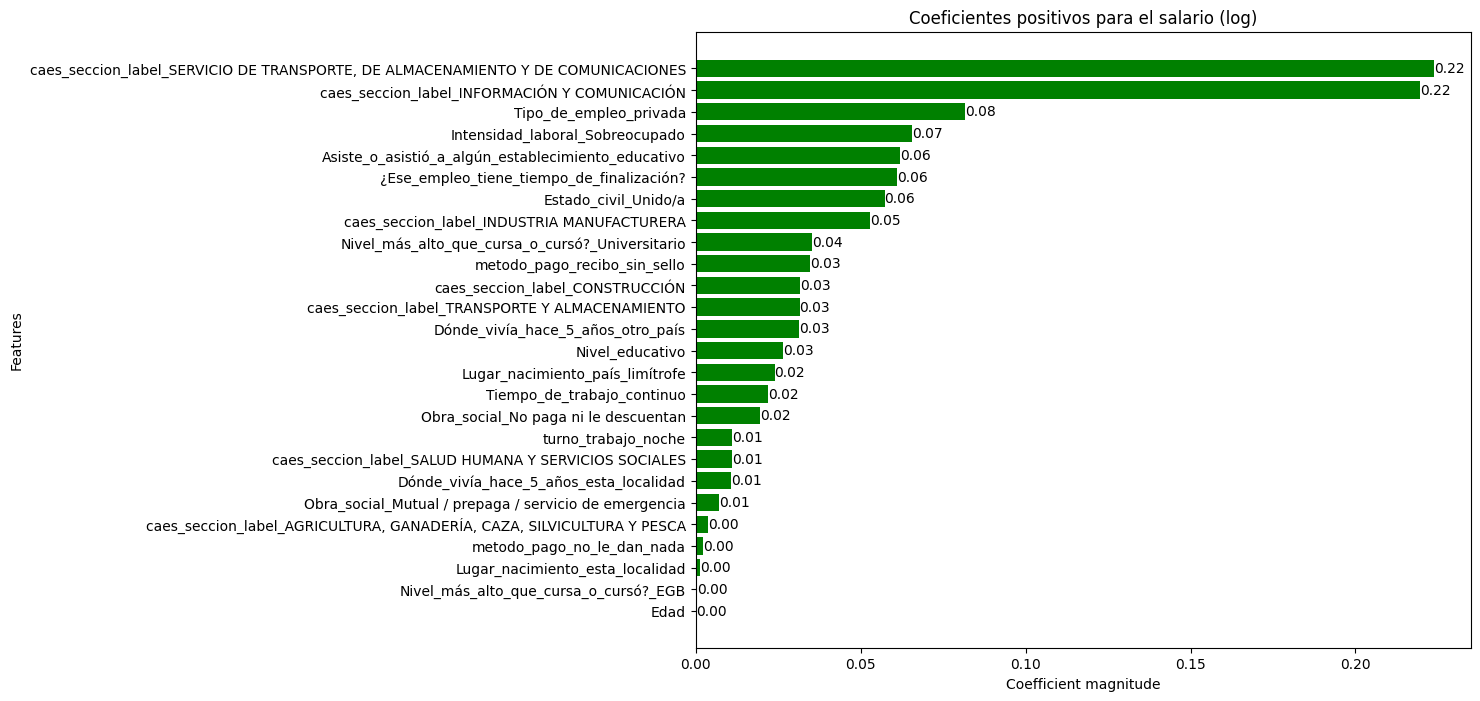

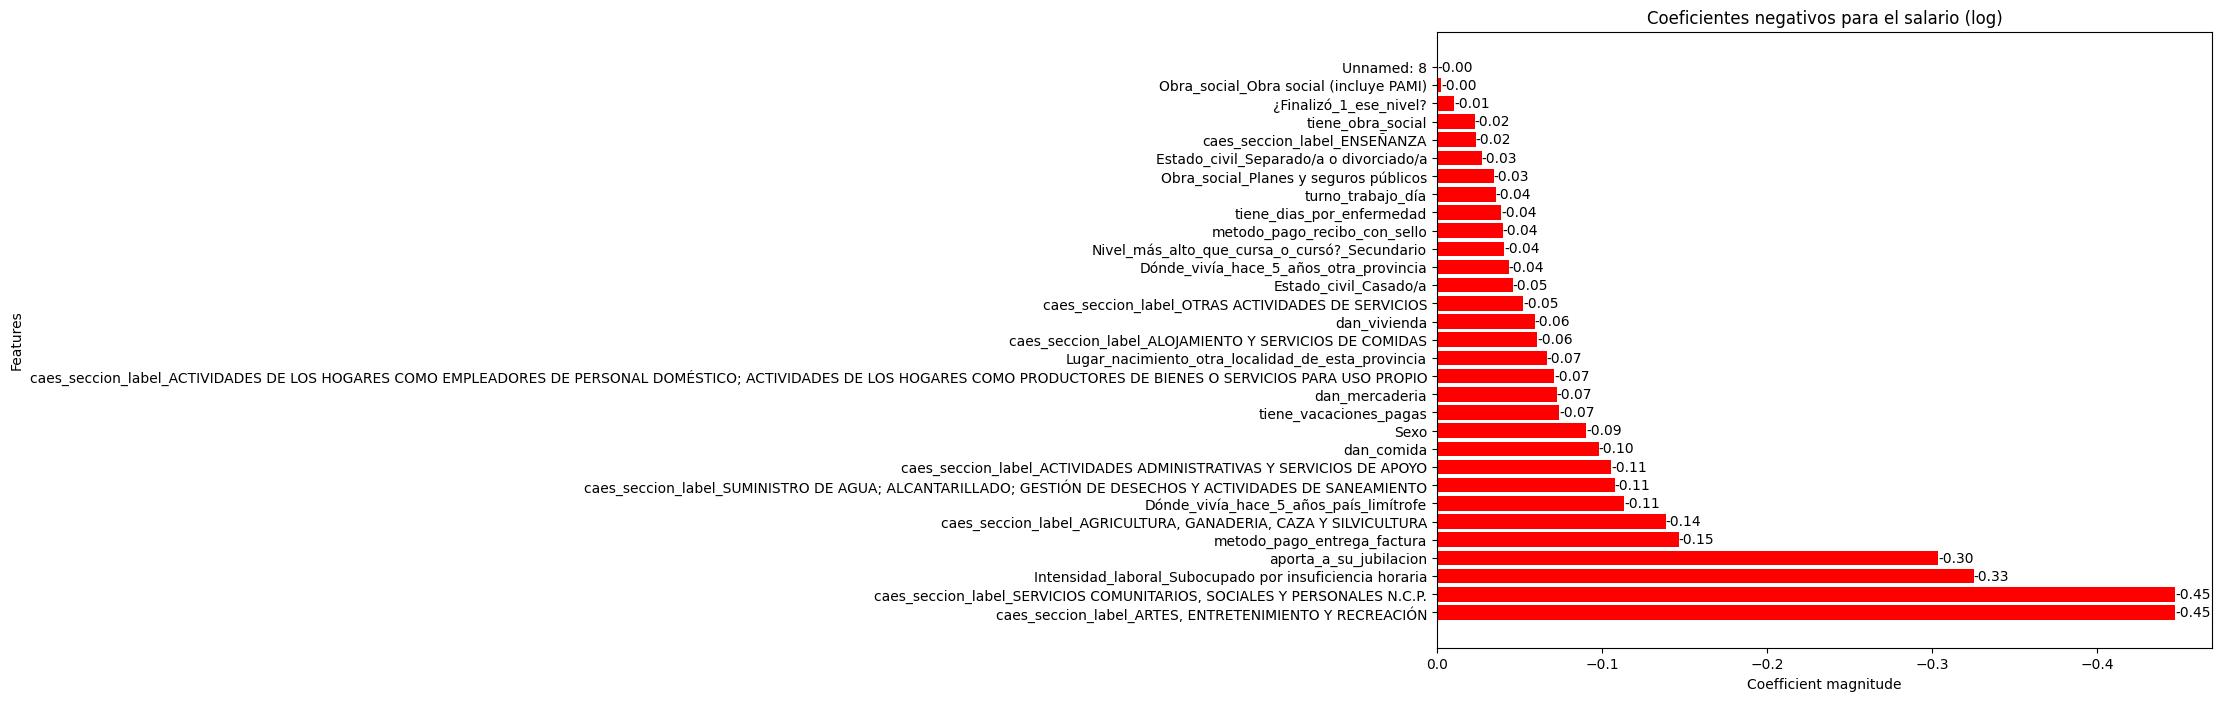

In [ ]:
varaibles_no_utilzadas_4=["P21"]

for variable in varaibles_no_utilzadas_4:
    if variable in df_patagonico.columns:
        del df_patagonico[variable]
    else:
        print(variable, "no esta en el dataset")


variables_categoricas=df_patagonico.select_dtypes(include=['object']).columns
varaibles_cat=variables_categoricas.tolist()
ohe = OneHotEncoder(handle_unknown='ignore')
df_ohe = ohe.fit_transform(df_patagonico[varaibles_cat]).toarray()

feature_names = []
for i, cat in enumerate(ohe.categories_):
    for sub_cat in cat:
        feature_names.append(f"{varaibles_cat[i]}_{sub_cat}")

df_ohe = pd.DataFrame(df_ohe, columns=feature_names)


df_no_cat = df_patagonico.drop(columns=varaibles_cat)
df_no_cat.reset_index(drop=True, inplace=True)
df_ohe.reset_index(drop=True, inplace=True)
# Concatena df_no_cat y df_ohe
df_final = pd.concat([df_no_cat, df_ohe], axis=1)

X=df_final.drop(columns='P21_log')
y=df_final['P21_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = np.linspace(0.001, 1, 1)
lasso_cv = LassoCV(alphas=alphas, cv=5)  # Use 5-fold cross-validation
lasso_cv.fit(X_train, y_train)

# Get the coefficients
coef_lasso_cv = lasso_cv.coef_
intercept = lasso_cv.intercept_
score = lasso_cv.score(X_test, y_test)
# Print the coefficients
print("Coefficients:")
print(coef_lasso_cv)

# Get the best alpha
best_alpha = lasso_cv.alpha_

# Print the best alpha
print("\nBest alpha:")
print(best_alpha)
print(f"Model score: {score}")
print("")
print(f"Intercept: {intercept}")
y_pred = lasso_cv.predict(X_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))



coef = lasso_cv.coef_
features = X.columns

# Separar los coeficientes positivos y negativos
positive_coef = np.array([c if c > 0 else 0 for c in coef])
negative_coef = np.array([c if c < 0 else 0 for c in coef])

# Filtrar los índices de coeficientes positivos y negativos
positive_coef_indices = np.where(positive_coef > 0)[0]
negative_coef_indices = np.where(negative_coef < 0)[0]

# Filtrar las características y coeficientes positivos y negativos
positive_features = features[positive_coef_indices]
positive_values = positive_coef[positive_coef_indices]
negative_features = features[negative_coef_indices]
negative_values = negative_coef[negative_coef_indices]

# Ordenar las características y coeficientes positivos
sorted_positive_indices = np.argsort(positive_values)
sorted_positive_features = positive_features[sorted_positive_indices]
sorted_positive_values = positive_values[sorted_positive_indices]

# Ordenar las características y coeficientes negativos
sorted_negative_indices = np.argsort(negative_values)
sorted_negative_features = negative_features[sorted_negative_indices]
sorted_negative_values = negative_values[sorted_negative_indices]

# Gráfico de barras horizontal para los coeficientes positivos
plt.figure(figsize=(10, 8))
plt.barh(sorted_positive_features, sorted_positive_values, color='green')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes positivos para el salario (log)')

# Agregar anotaciones al comienzo de cada barra
for index, value in enumerate(sorted_positive_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

# Gráfico de barras horizontal para los coeficientes negativos (invertido)
plt.figure(figsize=(10, 8))
plt.barh(sorted_negative_features, sorted_negative_values, color='red')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes negativos para el salario (log)')
plt.gca().invert_xaxis()  # Invertir el eje x

# Agregar anotaciones afuera de cada barra
for index, value in enumerate(sorted_negative_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

#### Buenos Aires


Coefficients:
[-4.03672898e-02 -9.14251377e-02 -3.45308311e-03  0.00000000e+00
  1.41734433e-01  1.38170751e-02  2.13846090e-02  1.93869426e-04
  6.21785016e-02 -4.43490231e-02 -0.00000000e+00  3.86144900e-02
  0.00000000e+00 -2.19243715e-02 -1.10154169e-01 -4.41852726e-02
 -2.71809392e-02  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  2.51797227e-02  4.30662050e-02 -6.70975953e-03  0.00000000e+00
 -1.29323710e-01  1.53796461e-01 -2.20544275e-04 -4.09327471e-02
  5.31112595e-03 -0.00000000e+00  1.58388696e-01  0.00000000e+00
 -4.75632326e-02  0.00000000e+00 -2.76731027e-02 -3.73232832e-03
  3.49471605e-01  2.64834194e-02 -7.56868556e-02  0.00000000e+00
 -4.69225392e-02  0.00000000e+00  0.00000000e+00 -0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.88803016e-05
 -9.68533749e-02  1.29791408e-01 -1.93316536e-01 -0.00000000e+00
 -9.80370806e-02  5.50593993e-02 -1.20667456e-02  7.58932769e-02
 -0.00000000e+00  2.34770272e-01 -8.05058088e-02  1.43447350e-01
 -0.0000000

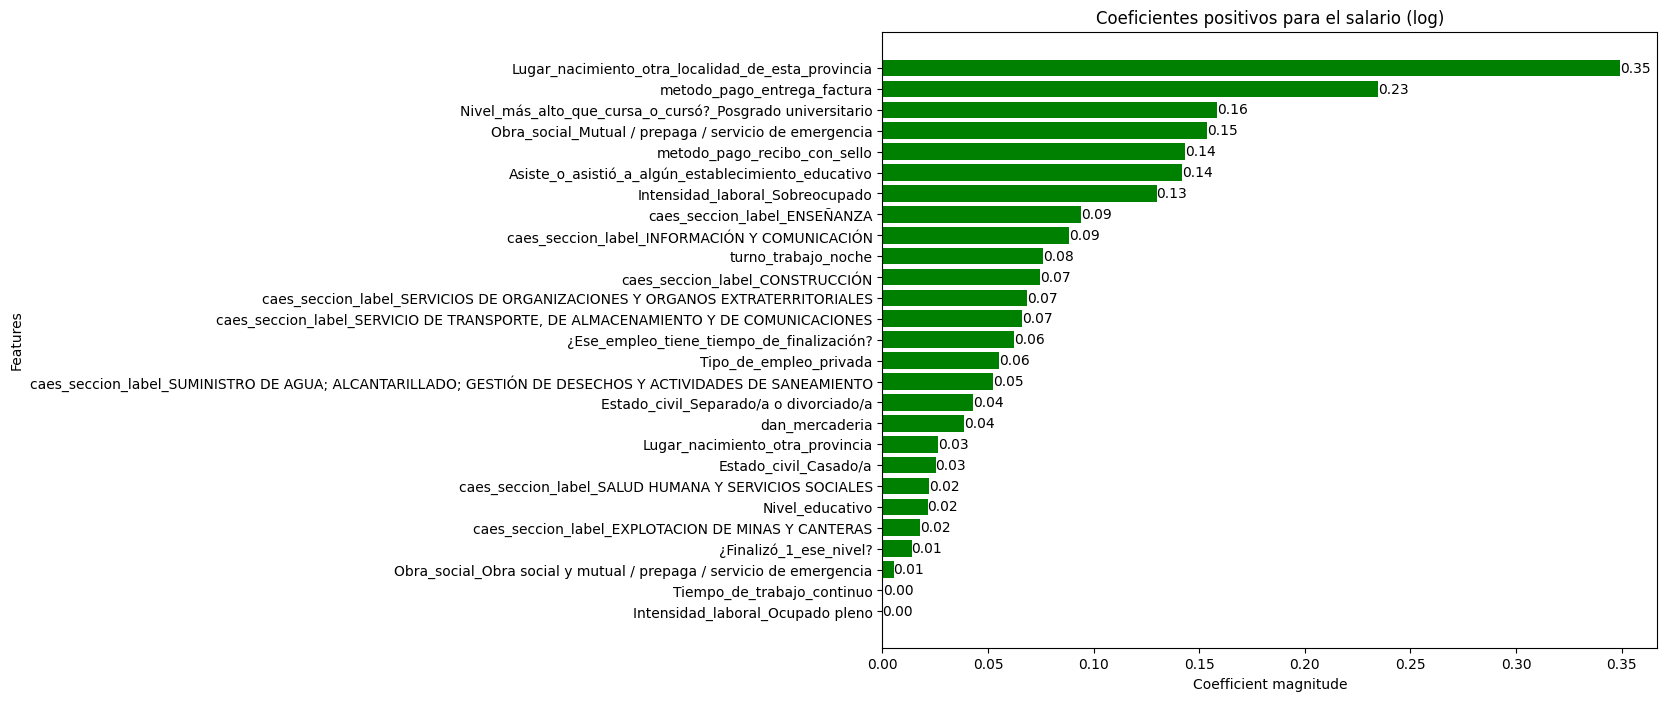

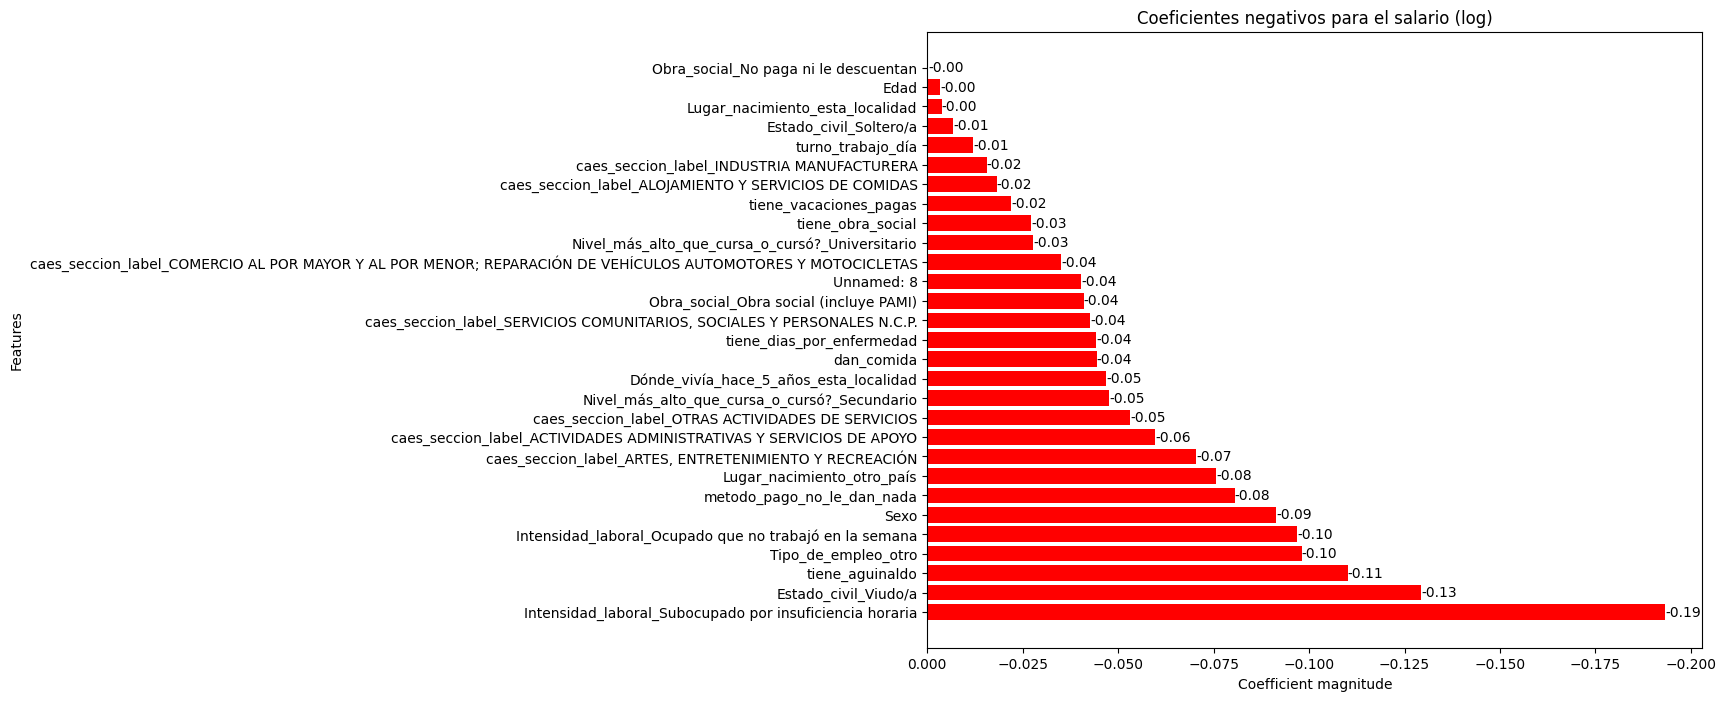

In [ ]:
varaibles_no_utilzadas_4=["P21"]

for variable in varaibles_no_utilzadas_4:
    if variable in df_gba.columns:
        del df_gba[variable]
    else:
        print(variable, "no esta en el dataset")


variables_categoricas=df_gba.select_dtypes(include=['object']).columns
varaibles_cat=variables_categoricas.tolist()
ohe = OneHotEncoder(handle_unknown='ignore')
df_ohe = ohe.fit_transform(df_gba[varaibles_cat]).toarray()

feature_names = []
for i, cat in enumerate(ohe.categories_):
    for sub_cat in cat:
        feature_names.append(f"{varaibles_cat[i]}_{sub_cat}")

df_ohe = pd.DataFrame(df_ohe, columns=feature_names)


df_no_cat = df_gba.drop(columns=varaibles_cat)
df_no_cat.reset_index(drop=True, inplace=True)
df_ohe.reset_index(drop=True, inplace=True)
# Concatena df_no_cat y df_ohe
df_final = pd.concat([df_no_cat, df_ohe], axis=1)

X=df_final.drop(columns='P21_log')
y=df_final['P21_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = np.linspace(0.001, 1, 1)
lasso_cv = LassoCV(alphas=alphas, cv=5)  # Use 5-fold cross-validation
lasso_cv.fit(X_train, y_train)

# Get the coefficients
coef_lasso_cv = lasso_cv.coef_
intercept = lasso_cv.intercept_
score = lasso_cv.score(X_test, y_test)
# Print the coefficients
print("Coefficients:")
print(coef_lasso_cv)

# Get the best alpha
best_alpha = lasso_cv.alpha_

# Print the best alpha
print("\nBest alpha:")
print(best_alpha)
print(f"Model score: {score}")
print("")
print(f"Intercept: {intercept}")
y_pred = lasso_cv.predict(X_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))



coef = lasso_cv.coef_
features = X.columns

# Separar los coeficientes positivos y negativos
positive_coef = np.array([c if c > 0 else 0 for c in coef])
negative_coef = np.array([c if c < 0 else 0 for c in coef])

# Filtrar los índices de coeficientes positivos y negativos
positive_coef_indices = np.where(positive_coef > 0)[0]
negative_coef_indices = np.where(negative_coef < 0)[0]

# Filtrar las características y coeficientes positivos y negativos
positive_features = features[positive_coef_indices]
positive_values = positive_coef[positive_coef_indices]
negative_features = features[negative_coef_indices]
negative_values = negative_coef[negative_coef_indices]

# Ordenar las características y coeficientes positivos
sorted_positive_indices = np.argsort(positive_values)
sorted_positive_features = positive_features[sorted_positive_indices]
sorted_positive_values = positive_values[sorted_positive_indices]

# Ordenar las características y coeficientes negativos
sorted_negative_indices = np.argsort(negative_values)
sorted_negative_features = negative_features[sorted_negative_indices]
sorted_negative_values = negative_values[sorted_negative_indices]

# Gráfico de barras horizontal para los coeficientes positivos
plt.figure(figsize=(10, 8))
plt.barh(sorted_positive_features, sorted_positive_values, color='green')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes positivos para el salario (log)')

# Agregar anotaciones al comienzo de cada barra
for index, value in enumerate(sorted_positive_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

# Gráfico de barras horizontal para los coeficientes negativos (invertido)
plt.figure(figsize=(10, 8))
plt.barh(sorted_negative_features, sorted_negative_values, color='red')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes negativos para el salario (log)')
plt.gca().invert_xaxis()  # Invertir el eje x

# Agregar anotaciones afuera de cada barra
for index, value in enumerate(sorted_negative_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

#### Cuyo


Coefficients:
[-9.74327140e-04 -7.89328050e-02 -1.07847545e-03 -3.95240358e-02
  3.79511819e-02 -2.58743576e-02  9.37496492e-03  1.11613642e-02
  1.40511984e-02 -9.34611803e-03 -0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.40342128e-02 -1.24985477e-01  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -1.63323097e-01  0.00000000e+00
 -0.00000000e+00  5.78167068e-02 -1.77813498e-02  1.89206750e-02
 -5.94926397e-02  0.00000000e+00  1.43561174e-02 -1.70761729e-02
  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -1.60057639e-02
  0.00000000e+00 -4.84634427e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -2.81228934e-02 -1.37868106e-02  7.11535587e-02
  0.00000000e+00  2.64442080e-02  0.00000000e+00 -3.11326380e-01
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.04047657e-05  1.47277487e-02  4.35575013e-02 -1.95974950e-01
 -0.00000000e+00 -1.51797481e-02  1.07410859e-01  0.00000000e+00
 -3.43001917e-02  7.52805485e-02 -0.00000000e+00 -0.00000000e+00
  0.0000000

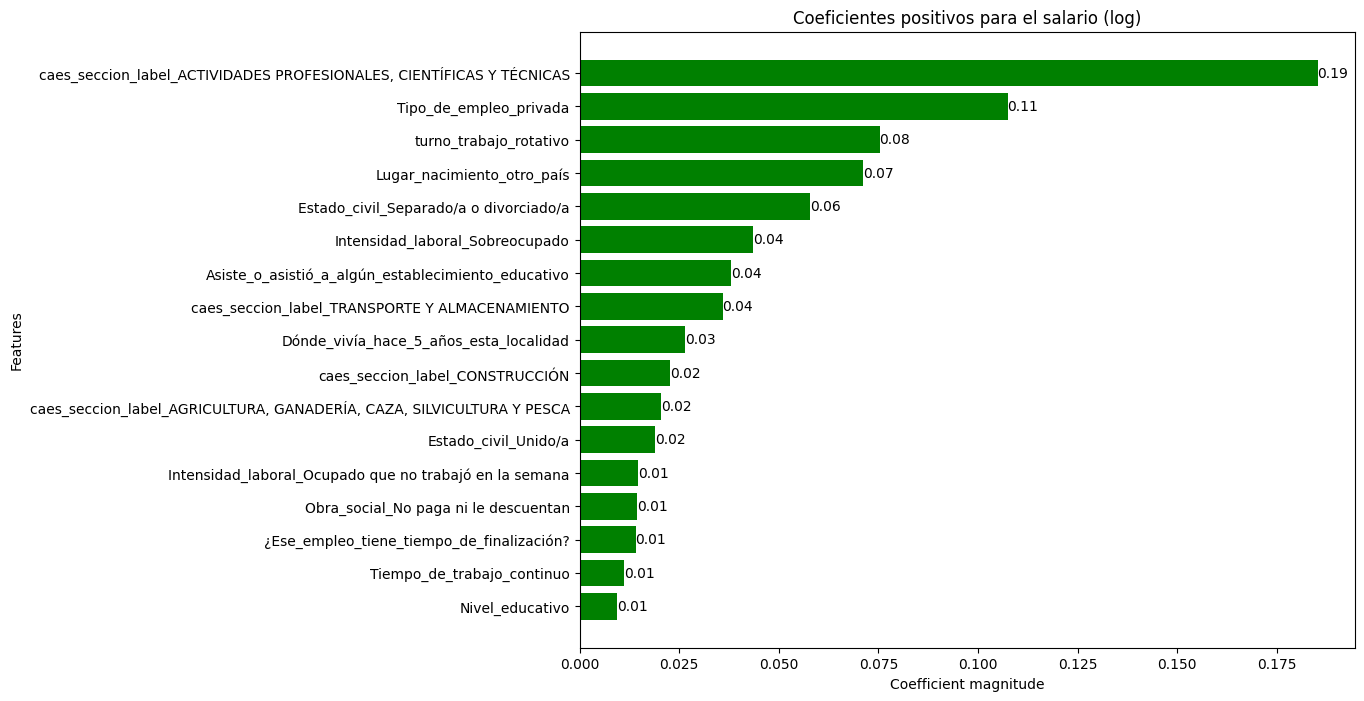

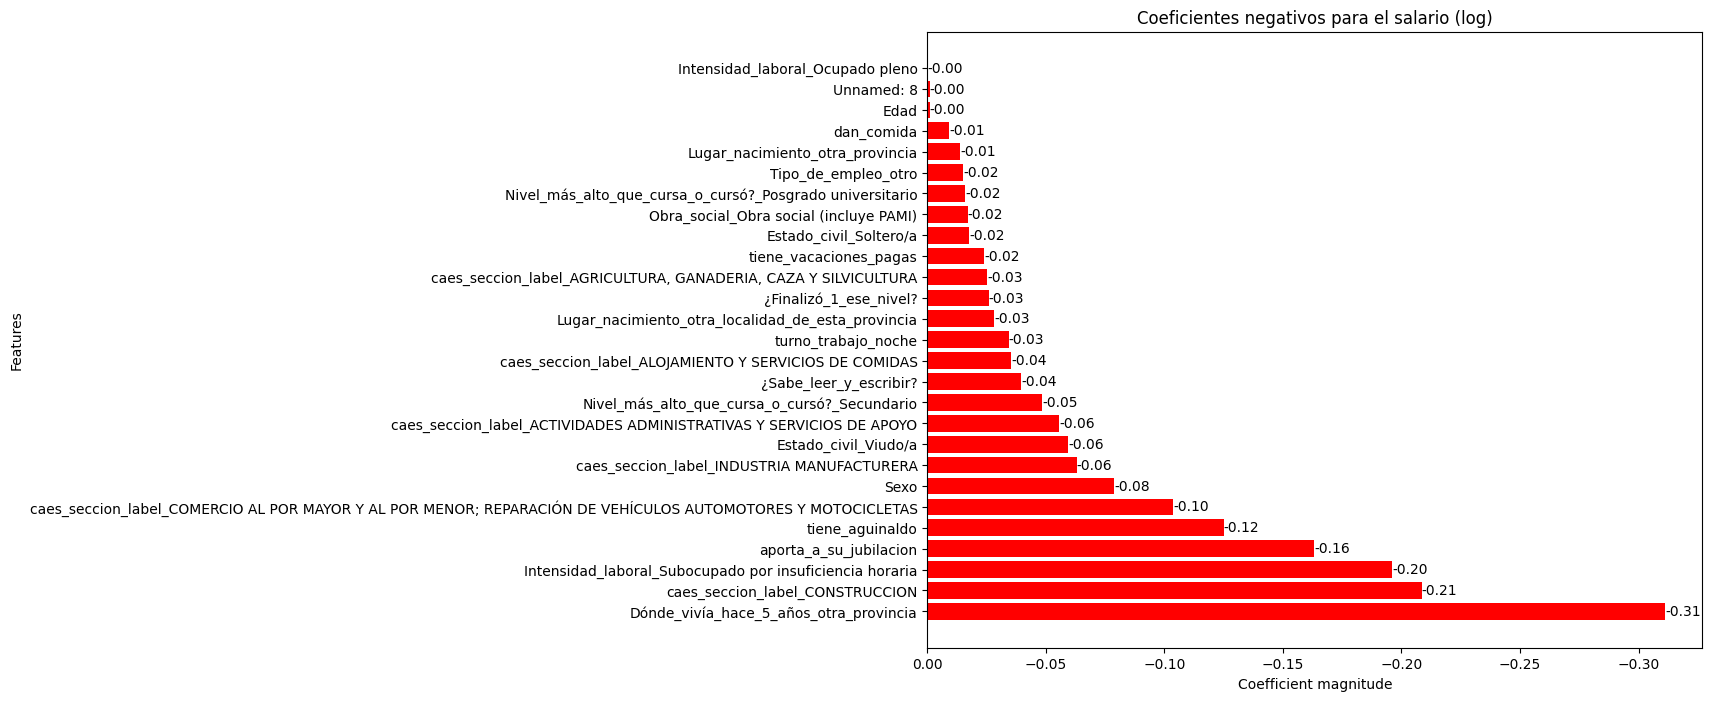

In [ ]:
varaibles_no_utilzadas_4=["P21"]

for variable in varaibles_no_utilzadas_4:
    if variable in df_cuyo.columns:
        del df_cuyo[variable]
    else:
        print(variable, "no esta en el dataset")


variables_categoricas=df_cuyo.select_dtypes(include=['object']).columns
varaibles_cat=variables_categoricas.tolist()
ohe = OneHotEncoder(handle_unknown='ignore')
df_ohe = ohe.fit_transform(df_cuyo[varaibles_cat]).toarray()

feature_names = []
for i, cat in enumerate(ohe.categories_):
    for sub_cat in cat:
        feature_names.append(f"{varaibles_cat[i]}_{sub_cat}")

df_ohe = pd.DataFrame(df_ohe, columns=feature_names)


df_no_cat = df_cuyo.drop(columns=varaibles_cat)
df_no_cat.reset_index(drop=True, inplace=True)
df_ohe.reset_index(drop=True, inplace=True)
# Concatena df_no_cat y df_ohe
df_final = pd.concat([df_no_cat, df_ohe], axis=1)

X=df_final.drop(columns='P21_log')
y=df_final['P21_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
alphas = np.linspace(0.001, 1, 1)
lasso_cv = LassoCV(alphas=alphas, cv=5)  # Use 5-fold cross-validation
lasso_cv.fit(X_train, y_train)

# Get the coefficients
coef_lasso_cv = lasso_cv.coef_
intercept = lasso_cv.intercept_
score = lasso_cv.score(X_test, y_test)
# Print the coefficients
print("Coefficients:")
print(coef_lasso_cv)

# Get the best alpha
best_alpha = lasso_cv.alpha_

# Print the best alpha
print("\nBest alpha:")
print(best_alpha)
print(f"Model score: {score}")
print("")
print(f"Intercept: {intercept}")
y_pred = lasso_cv.predict(X_test)

print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))



coef = lasso_cv.coef_
features = X.columns

# Separar los coeficientes positivos y negativos
positive_coef = np.array([c if c > 0 else 0 for c in coef])
negative_coef = np.array([c if c < 0 else 0 for c in coef])

# Filtrar los índices de coeficientes positivos y negativos
positive_coef_indices = np.where(positive_coef > 0)[0]
negative_coef_indices = np.where(negative_coef < 0)[0]

# Filtrar las características y coeficientes positivos y negativos
positive_features = features[positive_coef_indices]
positive_values = positive_coef[positive_coef_indices]
negative_features = features[negative_coef_indices]
negative_values = negative_coef[negative_coef_indices]

# Ordenar las características y coeficientes positivos
sorted_positive_indices = np.argsort(positive_values)
sorted_positive_features = positive_features[sorted_positive_indices]
sorted_positive_values = positive_values[sorted_positive_indices]

# Ordenar las características y coeficientes negativos
sorted_negative_indices = np.argsort(negative_values)
sorted_negative_features = negative_features[sorted_negative_indices]
sorted_negative_values = negative_values[sorted_negative_indices]

# Gráfico de barras horizontal para los coeficientes positivos
plt.figure(figsize=(10, 8))
plt.barh(sorted_positive_features, sorted_positive_values, color='green')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes positivos para el salario (log)')

# Agregar anotaciones al comienzo de cada barra
for index, value in enumerate(sorted_positive_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()

# Gráfico de barras horizontal para los coeficientes negativos (invertido)
plt.figure(figsize=(10, 8))
plt.barh(sorted_negative_features, sorted_negative_values, color='red')
plt.xlabel('Coefficient magnitude')
plt.ylabel('Features')
plt.title('Coeficientes negativos para el salario (log)')
plt.gca().invert_xaxis()  # Invertir el eje x

# Agregar anotaciones afuera de cada barra
for index, value in enumerate(sorted_negative_values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left')

plt.show()